In [54]:
import numpy as np
import pandas as pd
import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
import os 

!pip install pmdarima
import pmdarima

# time series analysis
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf #per me non servono!!
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.deterministic import DeterministicProcess
import warnings

#prophet
from fbprophet import Prophet
import itertools
from fbprophet.diagnostics import cross_validation, performance_metrics

#deep learning
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy import stats
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional, LeakyReLU

###Importo dei dati

In [3]:
drive.mount('/content/drive', force_remount=True)
os.chdir('/content/drive/MyDrive/SDMTSA')

Mounted at /content/drive


In [ ]:
data=pd.read_csv('TrainingSet.csv', sep=';', header=0, low_memory=False)
data.rename(columns={"DATA": "Date", "Ora": "Hour", "VALORE": "Value"}, inplace=True)

In [ ]:
#vedo se ci sono valori mancanti
data.info()
#non ci sono valori mancanti

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17518 entries, 0 to 17517
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    17518 non-null  object
 1   Hour    17518 non-null  int64 
 2   Value   17518 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 410.7+ KB


In [ ]:
#according to the standard of the dates the hours are from 0-23. So I replace 24 with 0
data['Hour']=data['Hour']-1
data['Hour']=data['Hour'].astype(str)
#trasform into datetime object
data['Date_Hour']=pd.to_datetime(data['Date']+'-'+data['Hour'],  format = "%Y-%m-%d-%H" )
#delete the columns that are no longer needed
data.drop(['Date', 'Hour'], axis='columns', inplace=True)

In [ ]:
#verificare se ci sono dati duplicati
print('Duplicates?', data['Date_Hour'].nunique()!=data.shape[0])

Duplicates? False


In [ ]:
#check that there are no missing dates within the dataset.
#Transform the datatime column (containing date and time) into index by also inserting the missing dates
r = pd.date_range(start=data['Date_Hour'].min(), end=data['Date_Hour'].max(), freq='H')
data.set_index('Date_Hour', inplace=True)
data=data.reindex(r)
data.index.rename('Date_Hour', inplace=True)

Guardo dove sono i dati mancanti

In [ ]:
#missing dates
data.index[data['Value'].isnull()]

DatetimeIndex(['2019-03-31 02:00:00', '2020-03-29 02:00:00',
               '2020-05-31 00:00:00', '2020-05-31 01:00:00',
               '2020-05-31 02:00:00', '2020-05-31 03:00:00',
               '2020-05-31 04:00:00', '2020-05-31 05:00:00',
               '2020-05-31 06:00:00', '2020-05-31 07:00:00',
               '2020-05-31 08:00:00', '2020-05-31 09:00:00',
               '2020-05-31 10:00:00', '2020-05-31 11:00:00',
               '2020-05-31 12:00:00', '2020-05-31 13:00:00',
               '2020-05-31 14:00:00', '2020-05-31 15:00:00',
               '2020-05-31 16:00:00', '2020-05-31 17:00:00',
               '2020-05-31 18:00:00', '2020-05-31 19:00:00',
               '2020-05-31 20:00:00', '2020-05-31 21:00:00',
               '2020-05-31 22:00:00', '2020-05-31 23:00:00'],
              dtype='datetime64[ns]', name='Date_Hour', freq=None)

Risoltano mancanti i valori associati alle datetime 2019-03-31 03:00:00 e 2020-03-29 03:00:00 (nota bene: tutti gli orari sono da considerare un'ora indietro a causa dell'operazione che ho fatto affinché i dati fossero nel formato standard di Pandas). La causa di questo vuoto è che quella data corrisponde al passaggio ad ora solare-legale. Decido quindi di sostituire i due valori mancanti con il valore all'ora precedente.

In [ ]:
#as professor said, for the two missing time values ​​I insert the value of the previous hour
data.loc["2019-03-31 02:00:00"][0]=data.loc["2019-03-31 01:00:00"][0]
data.loc["2020-03-29 02:00:00"][0]=data.loc["2020-03-29 01:00:00"][0]

Inoltre, mancano anche tutti valori del 2020-05-31. Non ho trovato niente di particolare quel giorno a parte che era la domenica di pentecoste. Poiché, come si vedrà più avanti, c'è una stagionalità settimanale oltre che giornaliera, ho deciso di sostituire i valori mancanti del 2020-05-31 con una media dei valori una settimana prima e una dopo alla stessa ora.

In [ ]:
a=0
for i in pd.date_range(start="2020-05-31 00:00:00", end="2020-05-31 23:00:00", freq='H'):
  data.loc[i,'Value']=(data.loc[pd.to_datetime(i)-datetime.timedelta(days=7),'Value']+data.loc[pd.to_datetime(i)+datetime.timedelta(days=7),'Value'])/2
  a=a+1

In [ ]:
#save the dataset in a csv file. I will use it to build the models to make predictions
data.to_csv('data_complete.csv')

### Visualizzazioni iniziali

In [ ]:
data=pd.read_csv('data_complete.csv', sep=',', header=0, low_memory=False, parse_dates=['Date_Hour'])
data.set_index('Date_Hour', inplace=True)

In [ ]:
data['Year']=data.index.year
data['Month']=data.index.month
data['Dayofweek']=data.index.day_name()
data['Day']=data.index.day
data['Hour']=data.index.hour

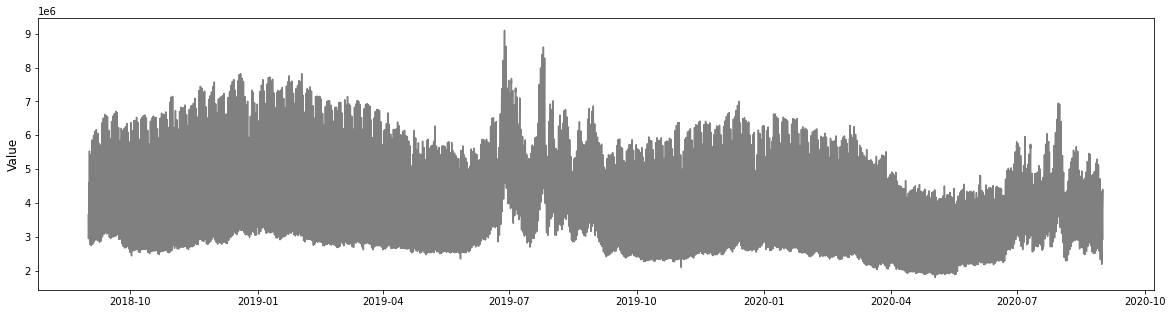

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(data['Value'], color='blue')
plt.ylabel('Value', fontsize = 12)
plt.show()

Sembrano esserci dei valori anomali a fine giugno e a fine luglio 2019. Sono quindi andata a esplorare l'intorno dell'anomalia del 2019 confrontandola con lo stesso periodo dell'anno successivo 2020. Da questi grafici non si evince niente senon che i due andamenti sembrano effettivamente diversi. 

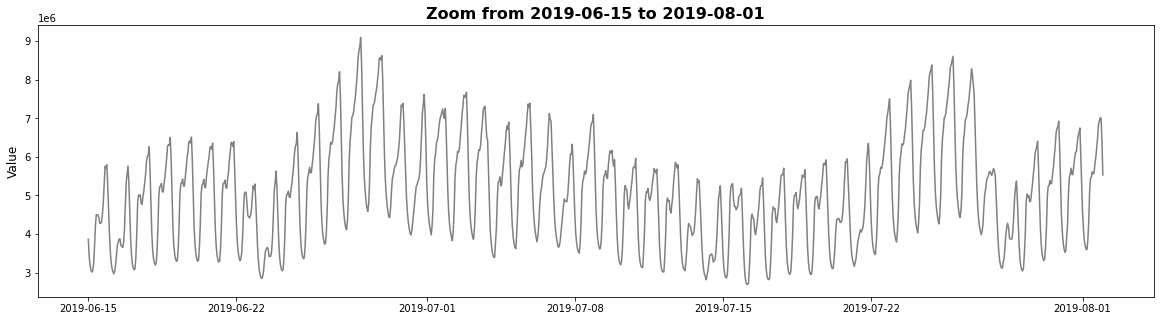

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(data.loc["2019-06-15 00:00:00":"2019-08-01 23:00:00"]['Value'], color='gray')
plt.ylabel('Value', fontsize = 12)
plt.title('Zoom from 2019-06-15 to 2019-08-01', fontsize = 16, fontdict=dict(weight='bold'))
plt.show()

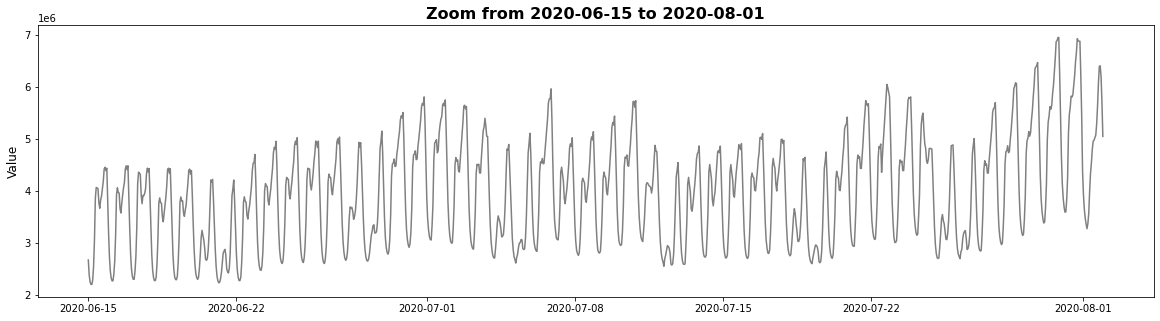

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(data.loc["2020-06-15 00:00:00":"2020-08-01 23:00:00"]['Value'], color='gray')
plt.ylabel('Value', fontsize = 12)
plt.title('Zoom from 2020-06-15 to 2020-08-01', fontsize = 16, fontdict=dict(weight='bold'))
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


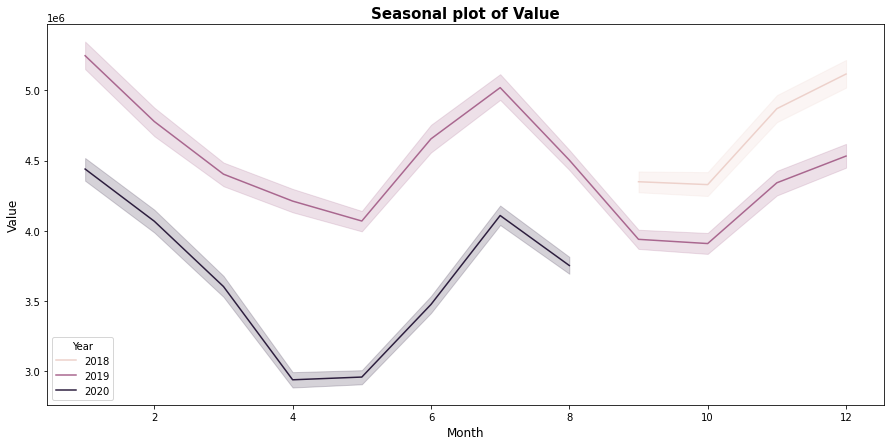

In [ ]:
#LINEPLOT: 
#By default, the plot aggregates over multiple y values at each value of x and 
#shows an estimate of the central tendency and a confidence interval for that estimate.

plt.figure(figsize=(15, 7))
sns.lineplot(data['Month'], data['Value'], hue=data['Year'])
plt.title('Seasonal plot of Value', fontsize = 15, loc='center', fontdict=dict(weight='bold'))
plt.xlabel('Month', fontsize = 12)
plt.ylabel('Value', fontsize = 12)
plt.show()

Si vede che esiste un andamento stagionale annuale con dei picchi nei mesi dicembre-gennaio e giugno-luglio. Si nota anche un trend decrescente al variare degli anni. Inoltre, nei mesi di marzo-aprile-maggio 2020 si notano chiaramente dei trend decrescenti dovuti molto probabilmente alla pandemia COVID-19.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


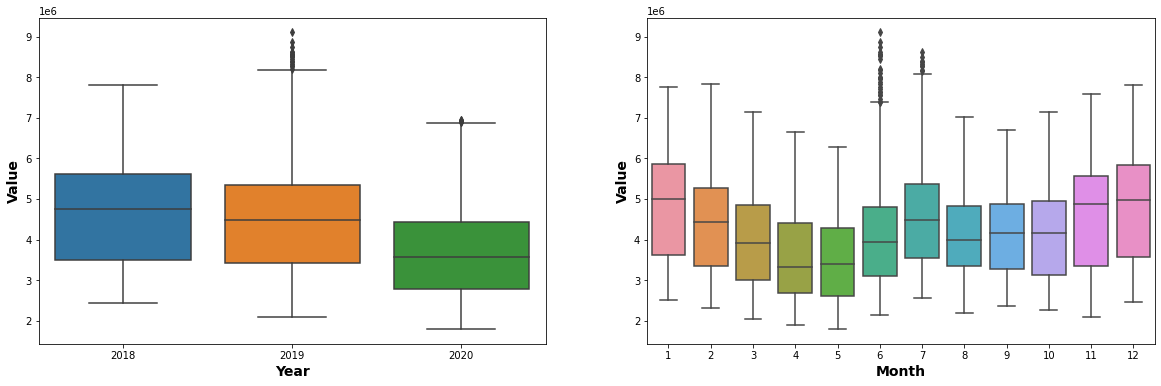

In [ ]:
#boxplot del valore rispetto a mese e anno
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

sns.boxplot(data['Year'], data['Value'], ax=ax[0])
ax[0].set_xlabel('Year', fontsize = 14, fontdict=dict(weight='bold'))
ax[0].set_ylabel('Value', fontsize = 14, fontdict=dict(weight='bold'))


sns.boxplot(data['Month'], data['Value'], ax=ax[1])
ax[1].set_xlabel('Month', fontsize = 14, fontdict=dict(weight='bold'))
ax[1].set_ylabel('Value', fontsize = 14, fontdict=dict(weight='bold'))
plt.show()

Dai boxplot di sinistra si osserva un trend decrescente al variare degli anni. Inoltre, sembrano presenti numerosi outlier nell'anno 2019 come ce lo aspettavamo. Anche nei boxplot di destra, i mesi dicembre-gennaio e giugno-luglio mostrano che esiste un andamento intra annuo. 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


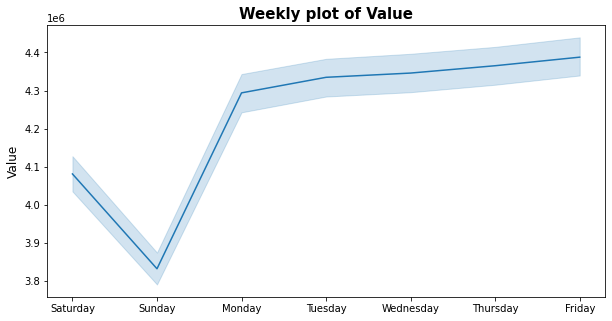

In [ ]:
plt.figure(figsize=(10, 5))
sns.lineplot(data['Dayofweek'], data['Value'])
plt.title('Weekly plot of Value', fontsize = 15, loc='center', fontdict=dict(weight='bold'))
plt.ylabel('Value', fontsize = 12)
plt.xlabel('', fontsize = 12)
plt.show()

Sembra esserci anche un'andamento intra settimanale: i valori registrati del sabato e della domenica sono decisamente più bassi di quelli del resto della settimana. 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


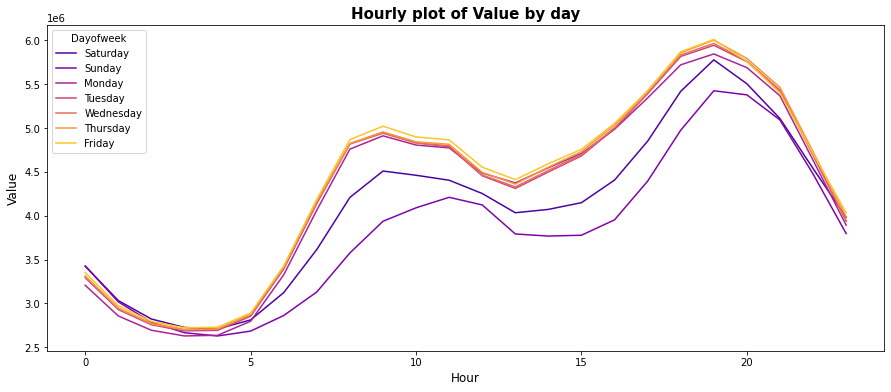

In [ ]:
plt.figure(figsize=(15, 6))
sns.lineplot(data['Hour'], data['Value'], hue=data['Dayofweek'], ci=None, palette="plasma")
plt.title('Hourly plot of Value by day', fontsize = 15, loc='center', fontdict=dict(weight='bold'))
plt.xlabel('Hour', fontsize = 12)
plt.ylabel('Value', fontsize = 12)
plt.show()

Andando a guardare più nello specifico si nota un andamento infragiornaliero con picchi tra le 9 e le 11 e tra le 15 e le 21. Gli andamenti rimangono molto simili per i giorni lavorativi della settimana. Invece per il sabato e la domenica l'andamento è simile ma il trend è più basso.  

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


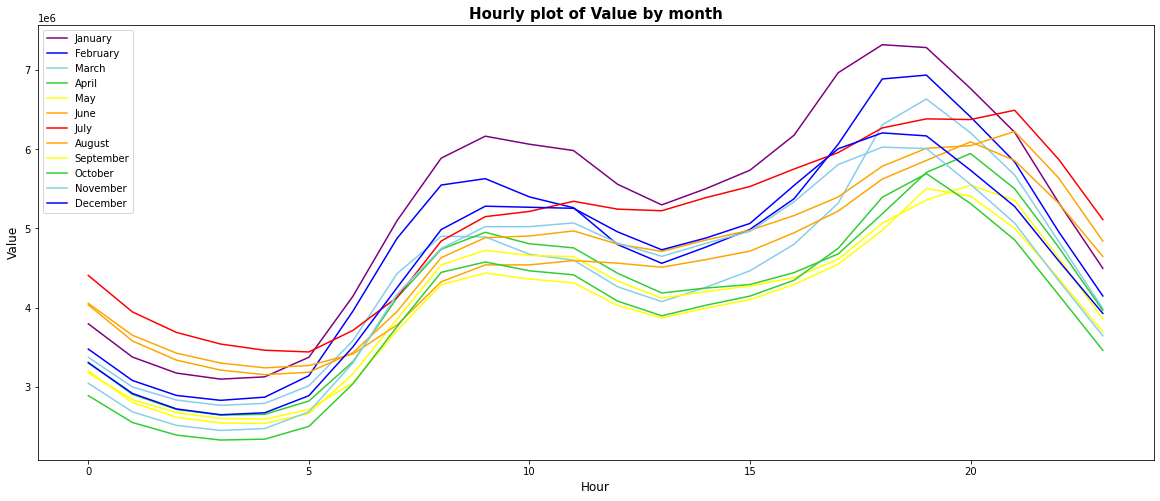

In [ ]:
plt.figure(figsize=(20, 8))
sns.lineplot(data.loc["2019-01-01 00:00:00":"2019-12-31 23:00:00"]['Hour'], data['Value'], hue=data['Month'], ci=None, 
             palette=["purple","blue","skyblue","limegreen","yellow","orange","red","orange","yellow","limegreen","skyblue","blue"])
plt.title('Hourly plot of Value by month', fontsize = 15, loc='center', fontdict=dict(weight='bold'))
plt.xlabel('Hour', fontsize = 12)
plt.ylabel('Value', fontsize = 12)
plt.legend(['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])
plt.show()

La stagionalità giornaliera sembra cambiare al variare dei mesi dell'anno. Nei mesi invernali si vedono con più chiarezza due picchi ben distinti: uno alla mattina dalle 9 alle 12 e uno al pomeriggio dalle 15 alle 20. Nei mesi estivi invece si nota un unico picco giornaliero dalle ora che vanno dalle 10 alle 20. 

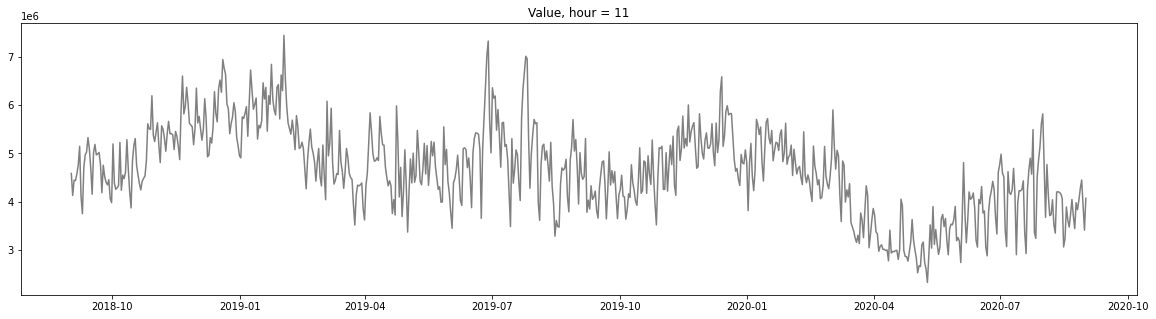

In [ ]:
hour=11
data_hour=data[data['Hour']==hour]
plt.figure(figsize=(20, 5))
plt.plot(data_hour['Value'], color='gray')
plt.title('Value, hour = {}'.format(hour) , fontsize = 12)
plt.show()

In [ ]:
data['Date']=pd.to_datetime(data['Year'].astype('str')+'-'+data['Month'].astype('str')+'-'+data['Day'].astype('str'),  format = "%Y-%m-%d" )
pivot=data.pivot_table(index='Date', values='Value', aggfunc='mean')

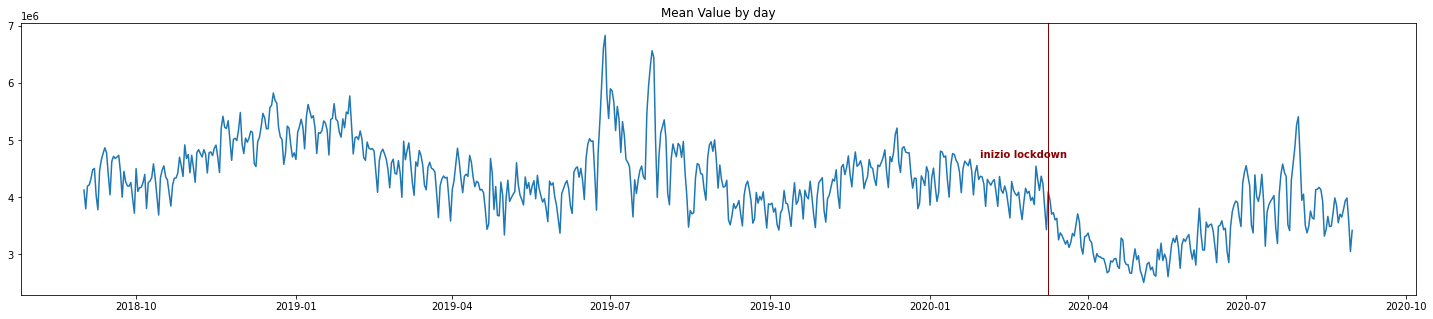

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.figure(figsize=(25,5))
plt.plot(pivot['Value'])
plt.axvline(x=pivot.index[pivot.index=="2020-03-09"], color='darkred', linewidth=1)
plt.text(pivot.index[pivot.index=="2020-01-30"], 4.7e06, 'inizio lockdown',  fontdict=dict(weight='bold'), color='darkred')
plt.title('Mean Value by day')
plt.show()
plt.savefig('destination_path.png', format='png')

###Divisione train e validation set

In [ ]:
train=data.loc[:"2020-04-30 23:00:00"]
validation=data.loc["2020-05-01 00:00:00":]

In [ ]:
print('Observations Train: {} --- {}%'.format(len(train), (round(len(train)/len(data)*100, 2))))
print('Observations Validation: {} --- {}%'.format(len(validation), (round(len(validation)/len(data)*100, 2))))

Observations Train: 14592 --- 83.17%
Observations Validation: 2952 --- 16.83%


## 1.a. Arima

In [ ]:
def adf_test(timeseries):
  '''
  ADF test is used to determine the presence of unit root in the series, and hence helps in understand if the series is stationary or not. 
  The null and alternate hypothesis of this test are:
  Null Hypothesis: The series has a unit root.
  Alternate Hypothesis: The series has no unit root.
  If the null hypothesis in failed to be rejected, this test may provide evidence that the series is non-stationary.
  '''
  print ('Results of Dickey-Fuller Test:')
  dftest = adfuller(timeseries, autolag='AIC')
  dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
  for key,value in dftest[4].items():
      dfoutput['Critical Value (%s)'%key] = value
  print (dfoutput)

In [ ]:
def kpss_test(timeseries):
  '''
  KPSS is another test for checking the stationarity of a time series. The null and alternate hypothesis for the KPSS test are opposite that of the ADF test.
  Null Hypothesis: The process is trend stationary.
  Alternate Hypothesis: The series has a unit root (series is not stationary).
  '''
  print ('Results of KPSS Test:')
  kpsstest = kpss(timeseries, regression='c')
  kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
  for key,value in kpsstest[3].items():
      kpss_output['Critical Value (%s)'%key] = value
  print (kpss_output)

In [ ]:
#Mean Absolute Error 
def mean_absolute_error(y_true, y_pred): 
  return round(np.mean(np.abs(y_true - y_pred)), 1)

In [ ]:
def arima_model(p, d, q, P, D, Q, x_train, x_val):
  model = sm.tsa.statespace.SARIMAX(train['Value'],
                                    order=(p, d, q), seasonal_order=(P, D, Q, 24),
                                    exog=x_train,
                                    enforce_stationarity=False, enforce_invertibility=False)
  model = model.fit(disp=0, low_memory=True)
  print('SARIMA({},{},{})({},{},{})24 with AIC:{}'.format(p, d, q, P, D, Q, round(model.aic, 0)))
  
  min=model.loglikelihood_burn
  # predict on TRAIN
  predicted_train = model.get_prediction(start=train.index[min], end=train.index[-1])
  predicted_train_mean = predicted_train.predicted_mean
  residui_train=train['Value'][min:]-predicted_train_mean

  # predict on VALIDATION
  predicted_val = model.get_prediction(start=validation.index[0], end=validation.index[-1], exog=x_val)
  predicted_val_mean = predicted_val.predicted_mean
  residui_val=validation['Value']-predicted_val_mean

  print("MAE train:", mean_absolute_error(train['Value'][min:], predicted_train_mean))
  print("MAE validation:", mean_absolute_error(validation['Value'], predicted_val_mean),'\n')
  return (predicted_train_mean, predicted_val_mean, residui_train, min)

In [ ]:
def arima_model_log(p, d, q, P, D, Q, x_train, x_val):
  model = sm.tsa.statespace.SARIMAX(np.log(train['Value']),
                                    order=(p, d, q), seasonal_order=(P, D, Q, 24),
                                    exog=x_train,
                                    enforce_stationarity=False, enforce_invertibility=False)
  model = model.fit(disp=0, low_memory=True)
  print('SARIMA({},{},{})({},{},{})24 with AIC:{}'.format(p, d, q, P, D, Q, round(model.aic, 0)))

  min=model.loglikelihood_burn
  #predict on TRAIN
  predicted_train = model.get_prediction(start=train.index[min], end=train.index[-1])
  predicted_train_mean = np.exp(predicted_train.predicted_mean)
  residui_train=train['Value'][min:]-predicted_train_mean

  # predict on VALIDATION
  predicted_val = model.get_prediction(start=validation.index[0], end=validation.index[-1], exog=x_val)
  predicted_val_mean = np.exp(predicted_val.predicted_mean)
  residui_val=validation['Value']-predicted_val_mean

  print("MAE train:", mean_absolute_error(train['Value'][min:], predicted_train_mean))
  print("MAE validation:", mean_absolute_error(validation['Value'], predicted_val_mean),'\n')
  return (predicted_train_mean, predicted_val_mean, residui_train, min)

In [ ]:
def plot_finale(train, validation, predicted_train_mean, predicted_val_mean, min):
  # prediction on TRAIN
  plt.figure(figsize=(25, 7))
  plt.title('Prediction on TRAIN')
  plt.plot(train['Value'][min:], color='dimgrey', label='Real')
  plt.plot(predicted_train_mean[min:], color='darkred', label='Predect', alpha=0.7)
  plt.ylabel('Value')
  plt.legend()
  plt.show()

  # prediction on TRAIN and VALIDATION
  plt.figure(figsize=(25, 5))
  plt.title('Prediction on TRAIN and VALIDATION')
  plt.plot(train['Value'], color='dimgrey', label='Train')
  plt.plot(validation['Value'], color='darkblue', label='Real')
  plt.plot(predicted_val_mean, color='tomato', label='Predect', alpha=0.7)
  plt.ylabel('Value')
  plt.legend()
  plt.show()

  # prediction on VALIDATION
  plt.figure(figsize=(25, 5))
  plt.title('Prediction on VALIDATION')
  plt.plot(validation['Value'], color='darkblue', label='Validation')
  plt.plot(predicted_val_mean, color='tomato', label='Predect', alpha=0.9)
  plt.ylabel('Value')
  plt.legend()
  plt.show()

  # figure on the first part of VALIDATION
  plt.figure(figsize=(25, 5))
  plt.title('Focus on the first part of VALIDATION')
  plt.plot(validation['Value'][:800], color='darkblue', label='Real')
  plt.plot(predicted_val_mean[:800], color='tomato', label='Predect', alpha=0.9)
  plt.ylabel('Value')
  plt.legend()
  plt.show()

  # figure on the last part of VALIDATION
  plt.figure(figsize=(25, 5))
  plt.title('Focus on the last part of VALIDATION')
  plt.plot(validation['Value'][2000:], color='darkblue', label='Real')
  plt.plot(predicted_val_mean[2000:], color='tomato', label='Predect', alpha=0.9)
  plt.ylabel('Value')
  plt.legend()
  plt.show()

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive', force_remount=True)
os.chdir('/content/drive/MyDrive/SDMTSA')

Mounted at /content/drive


In [ ]:
data=pd.read_csv('data_complete.csv', sep=',', header=0, low_memory=False, parse_dates=['Date_Hour'])
data.set_index('Date_Hour', inplace=True)
data.index.freq='H'

In [ ]:
#Train / validation split
train = data.loc[:"2020-04-30 23:00:00"]
validation = data.loc["2020-05-01 00:00:00":]

In [ ]:
pivot = data.pivot_table(index='Date', values='Value', aggfunc=['mean', 'std'])

Per l'applicazione del modello ARIMA è necessario che la serie storica sia stazionaria, ovvero che le sue proprietà temporali non varino nel tempo. 
La trasformazione logaritmica può aiutare a stabilizzare la serie temporale in varianza. La differenza aiuta invece a stabilizzare la serie in media. 

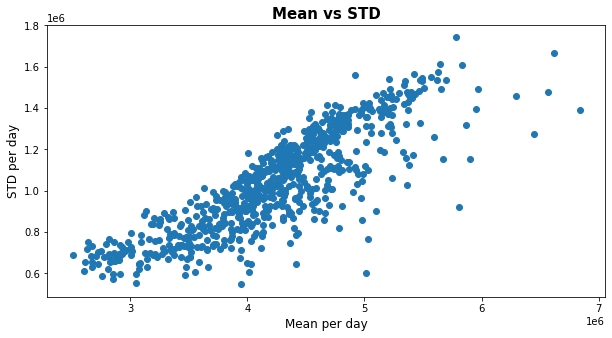

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(pivot['mean'], pivot['std'], 'o')
plt.title('Mean vs STD', fontsize = 15, loc='center', fontdict=dict(weight='bold'))
plt.ylabel('STD per day', fontsize = 12)
plt.xlabel('Mean per day', fontsize = 12)
plt.show()


Vari test permettono di verificare se una serie storica è stazionaria o meno. Il Dickey-Fuller ha come ipotesi nulla che almeno una radice unitaria sia presente nel modello autoregressivo. 

In [ ]:
#test Augmented Dickey-Fuller
adf_test(train['Value'])

Results of Dickey-Fuller Test:
Test Statistic                -5.810651e+00
p-value                        4.409576e-07
Lags Used                      4.200000e+01
Number of Observations Used    1.454900e+04
Critical Value (1%)           -3.430800e+00
Critical Value (5%)           -2.861739e+00
Critical Value (10%)          -2.566876e+00
dtype: float64


È possibile vedere come il p-value risulti piccolo (significativà 1%), rifiutando quindi l'ipotesi nulla. Quindi, la serie è stazionaria secondo il test ADF. 

Il test Kwiatkowski–Phillips–Schmidt–Shin (KPSS) ha come ipotesi nulla che la serie storica osservata sia stazionaria attorno ad un trend deterministico rispetto all'alternativa di una radice unitaria. 

In [ ]:
kpss_test(train['Value'])

Results of KPSS Test:
Test Statistic            9.070323
p-value                   0.010000
Lags Used                42.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1907: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


È possibile in questo caso rifiutare l'ipotesi nulla che la serie storica sia stazionaria. Quindi la serie non è stazionaria secondo il test KPSS. Poichè KPSS indica non stazionarietà e ADF indica stazionarietà, la serie è stazionaria per differenza. Si può quindi pensare di applicare una differenza a i dati. 

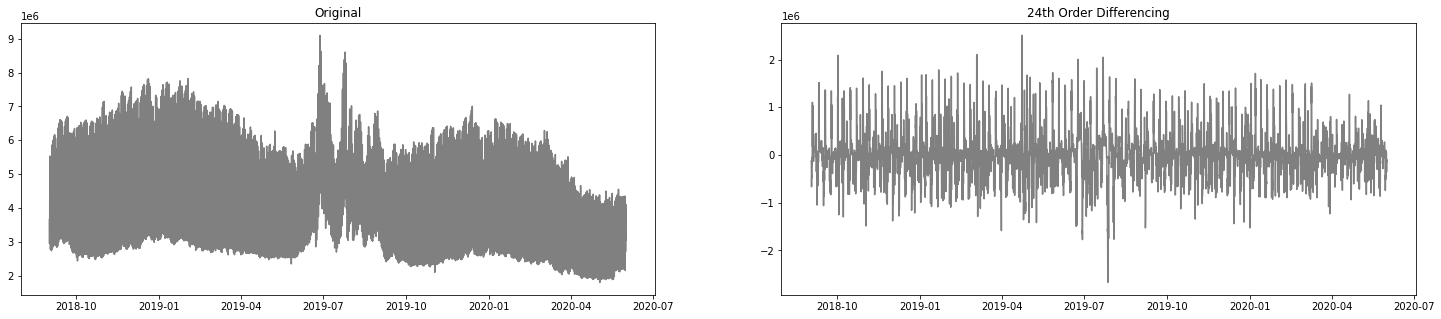

In [ ]:
plt.rcParams.update({'figure.figsize':(25,5)})
fig0, axes0 = plt.subplots(1, 2, sharex=True)

axes0[0].plot(train['Value'], color = 'gray')
axes0[0].set_title('Original')

axes0[1].plot(train['Value'].diff(24).dropna(), color = 'gray');
axes0[1].set_title('24th Order Differencing')
plt.show()

In [ ]:
adf_test(train['Value'].diff(24).dropna())

Results of Dickey-Fuller Test:
Test Statistic                   -22.449561
p-value                            0.000000
Lags Used                         42.000000
Number of Observations Used    14525.000000
Critical Value (1%)               -3.430800
Critical Value (5%)               -2.861739
Critical Value (10%)              -2.566876
dtype: float64


In [ ]:
kpss_test(train['Value'].diff(24).dropna())

Results of KPSS Test:
Test Statistic            0.018266
p-value                   0.100000
Lags Used                42.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


L'ipotesi nulla è rifiutata per il Dickey-Fuller test ed è accettata per il KPPS test. Quindi entrambi per entrambi i test, è un processo integrato di ordine 24. La serie storica $\Delta^{24}Z_t$ è stazionaria. 

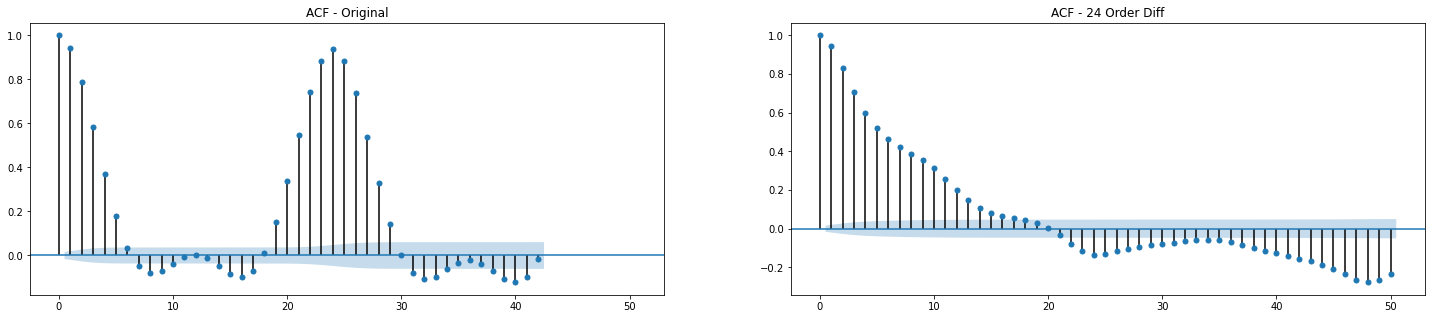

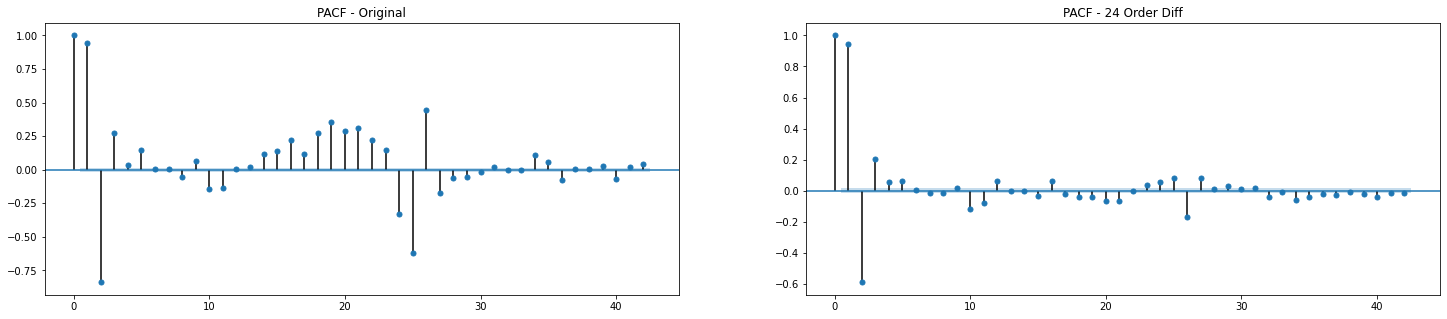

In [ ]:
plt.rcParams.update({'figure.figsize':(25,5)})
fig1, axes1 = plt.subplots(1, 2, sharex=True)
plot_acf(train['Value'], ax=axes1[0])
axes1[0].set_title('ACF - Original')
plot_acf(train['Value'].diff(24).dropna(), ax=axes1[1], lags=50)
axes1[1].set_title('ACF - 24 Order Diff')

fig2, axes2 = plt.subplots(1, 2, sharex=True)
plot_pacf(train['Value'], ax=axes2[0])
axes2[0].set_title('PACF - Original')
plot_pacf(train['Value'].diff(24).dropna(), ax=axes2[1])
axes2[1].set_title('PACF - 24 Order Diff')
plt.show()

L’identificazione di un modello ARMA avviene per mezzo della funzione di autocorrelazione e della funzione di autocorrelazione parziale. Il grafico ACF rappresenta l'autocorrelazione di una serie storica. Il grafico dei dati originali mostra una stagionalità ogni 24 ore. Per questo motivo ho deciso di applicare una differenza sui dati di 24. Il grafico PACF - 24 Order Diff mostra che un potrebbe avere senso un ordine p = 1, p = 2 o p = 3. Per quanto riguarda la parte stagionale non si riesce bene a capire quanti picchi si potrebbero considerare significativi. Quindi inizio a considerare P = 1 e Q = 1. Per questo motivo decido di applicare il modello Arima faccendo variare i p e q da 0 a 3. 

In [ ]:
for p in range(4): 
  for q in range(4):
    _=arima_model(p, 0, q, 1, 1, 1, None, None)

SARIMA(0,0,0)(1,1,1)24 with AIC:417218.0
MAE train: 276458.0
MAE validation: 716203.0 

SARIMA(0,0,1)(1,1,1)24 with AIC:406377.0
MAE train: 157702.5
MAE validation: 710287.1 

SARIMA(0,0,2)(1,1,1)24 with AIC:400669.0
MAE train: 110341.7
MAE validation: 707535.0 

SARIMA(0,0,3)(1,1,1)24 with AIC:396015.0
MAE train: 87141.9
MAE validation: 707871.0 

SARIMA(1,0,0)(1,1,1)24 with AIC:383424.0
MAE train: 84912.7
MAE validation: 718818.9 

SARIMA(1,0,1)(1,1,1)24 with AIC:378389.0
MAE train: 69836.8
MAE validation: 711543.9 

SARIMA(1,0,2)(1,1,1)24 with AIC:377501.0
MAE train: 66466.6
MAE validation: 710414.0 

SARIMA(1,0,3)(1,1,1)24 with AIC:377347.0
MAE train: 65730.6
MAE validation: 709639.1 

SARIMA(2,0,0)(1,1,1)24 with AIC:377707.0
MAE train: 67167.6
MAE validation: 713421.9 

SARIMA(2,0,1)(1,1,1)24 with AIC:377324.0
MAE train: 65770.2
MAE validation: 711881.0 

SARIMA(2,0,2)(1,1,1)24 with AIC:377291.0
MAE train: 65584.2
MAE validation: 711547.3 

SARIMA(2,0,3)(1,1,1)24 with AIC:377267.0

In [ ]:
for p in range(4):
  for q in range(4):
    _=arima_model_log(p, 0, q, 1, 1, 1, None, None)

SARIMA(0,0,0)(1,1,1)24 with AIC:-29681.0
MAE train: 274785.7
MAE validation: 726388.8 

SARIMA(0,0,1)(1,1,1)24 with AIC:-46611.0
MAE train: 152181.4
MAE validation: 726320.8 

SARIMA(0,0,2)(1,1,1)24 with AIC:-57133.0
MAE train: 104576.2
MAE validation: 726938.0 



/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


SARIMA(0,0,3)(1,1,1)24 with AIC:-63102.0
MAE train: 82140.1
MAE validation: 727884.9 

SARIMA(1,0,0)(1,1,1)24 with AIC:-63294.0
MAE train: 82676.4
MAE validation: 726202.6 

SARIMA(1,0,1)(1,1,1)24 with AIC:-68421.0
MAE train: 66682.4
MAE validation: 727167.8 



/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


SARIMA(1,0,2)(1,1,1)24 with AIC:-69288.0
MAE train: 63291.2
MAE validation: 727247.9 



/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


SARIMA(1,0,3)(1,1,1)24 with AIC:-69391.0
MAE train: 62452.4
MAE validation: 726817.8 



/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


SARIMA(2,0,0)(1,1,1)24 with AIC:-68910.0
MAE train: 64429.8
MAE validation: 726196.4 



/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


SARIMA(2,0,1)(1,1,1)24 with AIC:-69326.0
MAE train: 62807.1
MAE validation: 726737.0 

SARIMA(2,0,2)(1,1,1)24 with AIC:-69379.0
MAE train: 62564.1
MAE validation: 726840.6 



/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


SARIMA(2,0,3)(1,1,1)24 with AIC:-69333.0
MAE train: 62770.6
MAE validation: 726879.8 

SARIMA(3,0,0)(1,1,1)24 with AIC:-69419.0
MAE train: 62409.3
MAE validation: 726862.3 



/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


SARIMA(3,0,1)(1,1,1)24 with AIC:-69204.0
MAE train: 63270.5
MAE validation: 727131.3 



/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


SARIMA(3,0,2)(1,1,1)24 with AIC:-69544.0
MAE train: 61865.9
MAE validation: 724401.9 



/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


SARIMA(3,0,3)(1,1,1)24 with AIC:-69551.0
MAE train: 61816.5
MAE validation: 725938.2 



La trasformazione logaritmica migliora il MAE del training ma non del validation. Per ora il modello che sembra funzionare meglio in termini di AIC è SARIMA(3,0,3)(1,1,1)$_{24}$


In [ ]:
predicted_train_mean, predicted_val_mean, residui_train, min= arima_model(3, 0, 3, 1, 1, 1, None, None)

SARIMA(3,0,3)(1,1,1)24 with AIC:376946.0
MAE train: 64858.7
MAE validation: 709131.6 



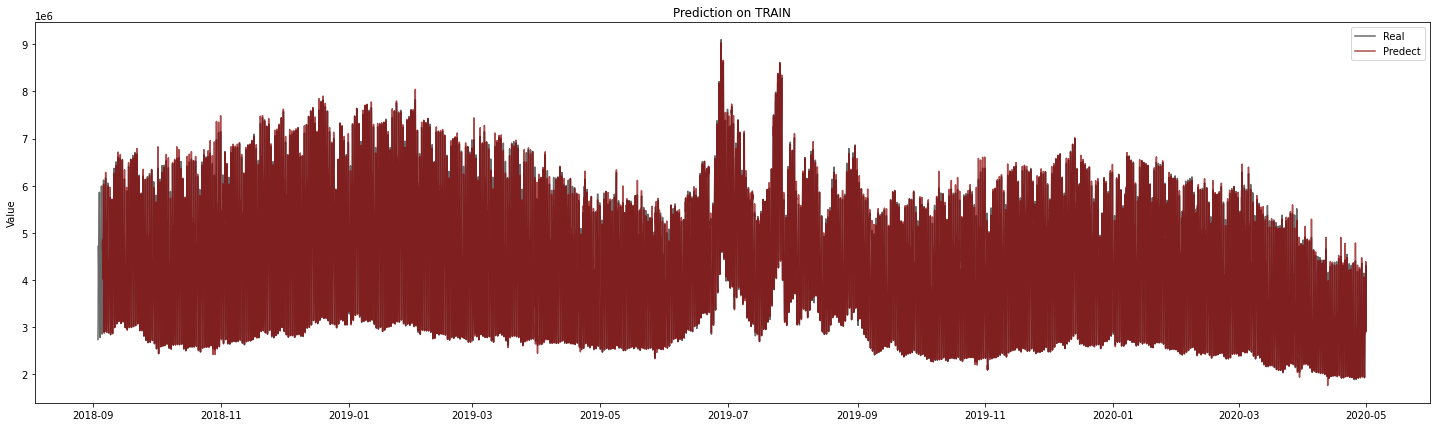

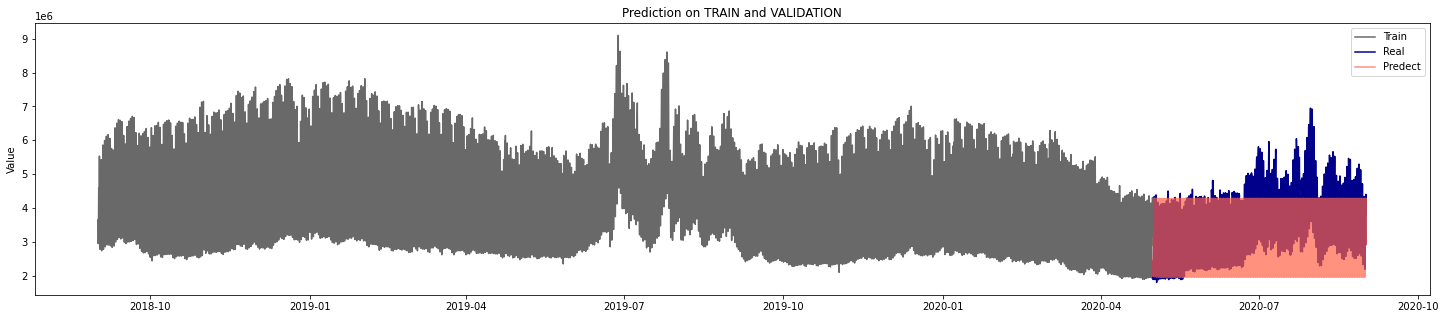

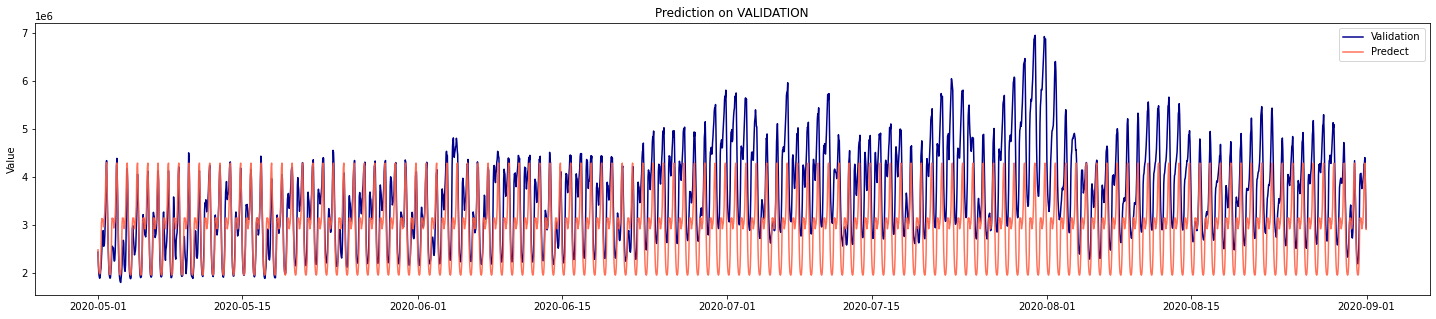

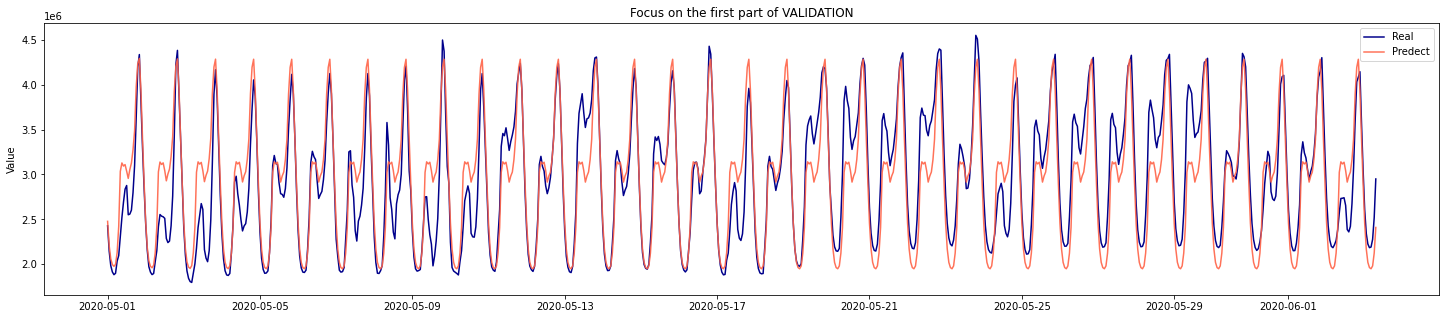

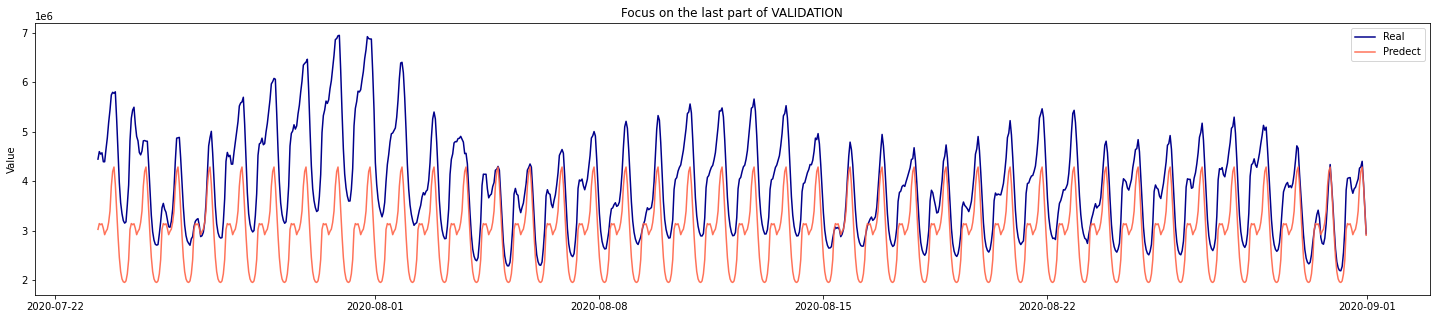

In [ ]:
plot_finale(train, validation, predicted_train_mean, predicted_val_mean, min)

Dai i vari plot si evince che il modello ha colto la stagionalità infragiornaliera ma non riesce a cogliere quella settimanale e infrannuale. 

## 1.b SARIMA con regressori di Fourier

Per riuscire a modellare gli altri tipi di stagionalità presenti nei dati è necessario aggiungere altri tipi di regressori quali le serie di Fourier. Per quanto riguarda la stagionalità settimanale inserisco una serie di fourier con periodo 24$*$7 = 168. Per la stagionalità annuale inserisco una serie di fourier con periodo 24$*$365,25 = 8766.

In [ ]:
for a in range(6, 13, 6):
  for b in range(5, 11, 5):
    four_sett = DeterministicProcess(data.index,  period=168, fourier=a)
    four_ann = DeterministicProcess(data.index,  period=24*365.25, fourier=b)
    print("weekly fourier armonics: {}, annual fourier armonics: {}" .format(a, b))
    four=four_sett.in_sample().merge( four_ann.in_sample(), left_index=True, right_index=True)

    x_train=four[:len(train)]
    x_val=four[len(train):]

    _=arima_model(3, 0, 3, 1, 1, 1, x_train, x_val)

weekly fourier armonics: 6, annual fourier armonics: 5
SARIMA(3,0,3)(1,1,1)24 with AIC:376258.0
MAE train: 64300.7
MAE validation: 325296.3 

weekly fourier armonics: 6, annual fourier armonics: 10
SARIMA(3,0,3)(1,1,1)24 with AIC:376271.0
MAE train: 64287.3
MAE validation: 379698.9 

weekly fourier armonics: 12, annual fourier armonics: 5


In [ ]:
four_sett = DeterministicProcess(data.index,  period=168, fourier=12)
four_ann = DeterministicProcess(data.index,  period=24*365.25, fourier=5)
print("weekly fourier armonics: {}, annual fourier armonics: {}" .format(12, 5))
four=four_sett.in_sample().merge( four_ann.in_sample(), left_index=True, right_index=True)

x_train=four[:len(train)]
x_val=four[len(train):]

_=arima_model(3, 0, 3, 1, 1, 1, x_train, x_val)

weekly fourier armonics: 12, annual fourier armonics: 5
SARIMA(3,0,3)(1,1,1)24 with AIC:1160898398.0
MAE train: 545056.1
MAE validation: 338712.5 



In [ ]:
four_sett = DeterministicProcess(data.index,  period=168, fourier=12)
four_ann = DeterministicProcess(data.index,  period=24*365.25, fourier=10)
print("weekly fourier armonics: {}, annual fourier armonics: {}" .format(12, 10))
four=four_sett.in_sample().merge( four_ann.in_sample(), left_index=True, right_index=True)

x_train=four[:len(train)]
x_val=four[len(train):]

_=arima_model(3, 0, 3, 1, 1, 1, x_train, x_val)

weekly fourier armonics: 12, annual fourier armonics: 10
SARIMA(3,0,3)(1,1,1)24 with AIC:1308199833.0
MAE train: 579614.4
MAE validation: 386710.4 



Il migliore modello è quello che considera un numero di armoniche settimanali pari a 6 e annuali pari a 5. Effettuo le previsioni con questo modello. 

In [ ]:
#fourier's harmonics
four_sett = DeterministicProcess(data.index,  period=168, fourier=6)
four_ann = DeterministicProcess(data.index,  period=24*365.25, fourier=5)
four = four_sett.in_sample().merge( four_ann.in_sample(), left_index=True, right_index=True)

x_train = four[:len(train)]
x_val = four[len(train):]

predicted_train_mean, predicted_val_mean, residui_train, min = arima_model(3, 0, 3, 1, 1, 1, x_train, x_val)

SARIMA(3,0,3)(1,1,1)24 with AIC:376258.0
MAE train: 64300.7
MAE validation: 325296.3 



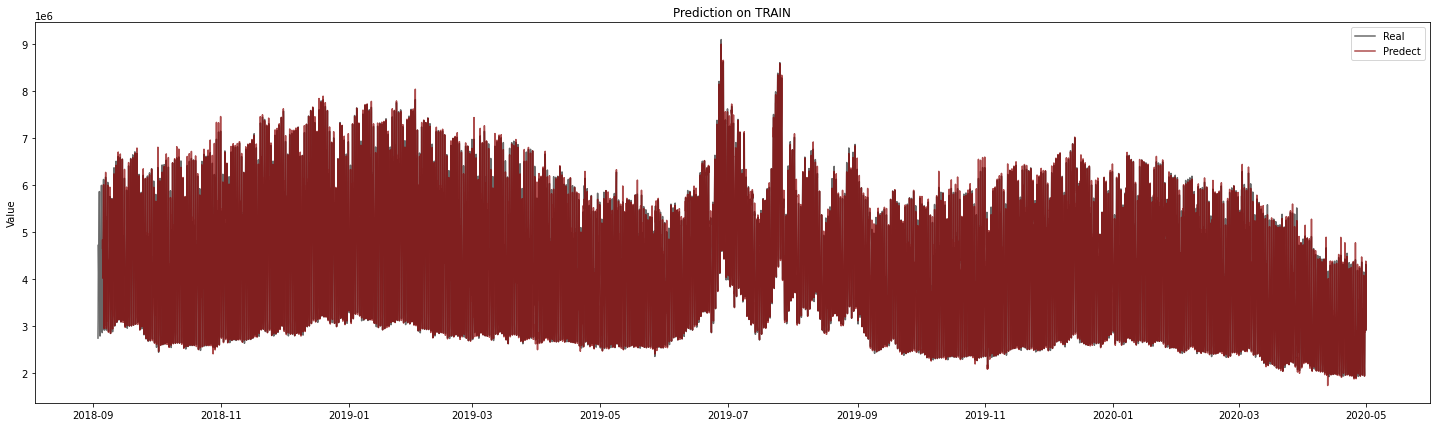

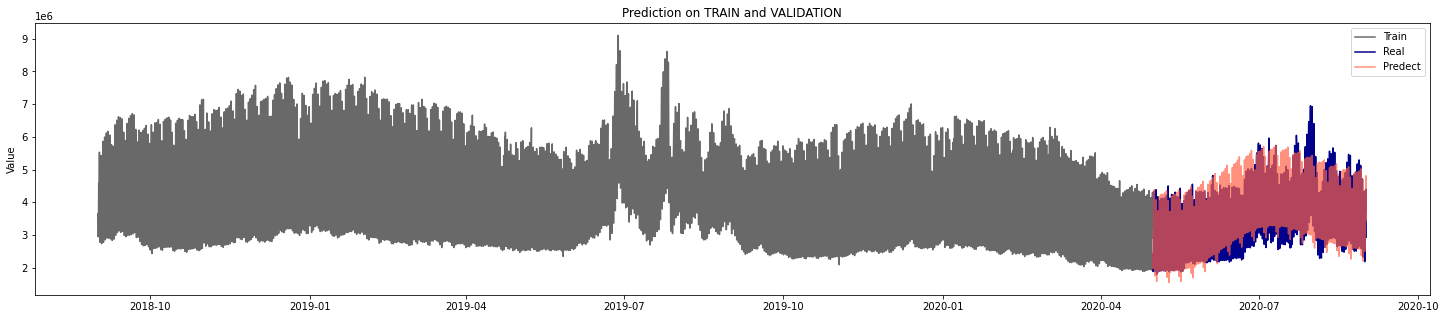

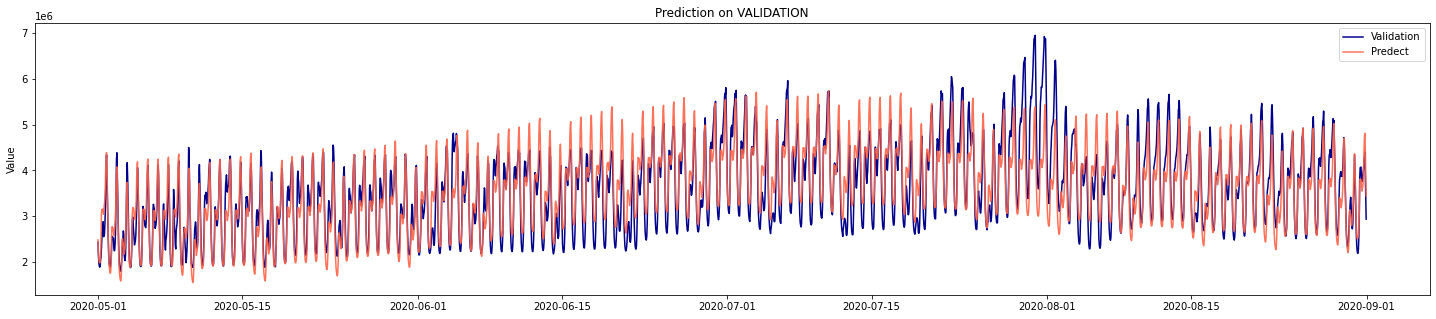

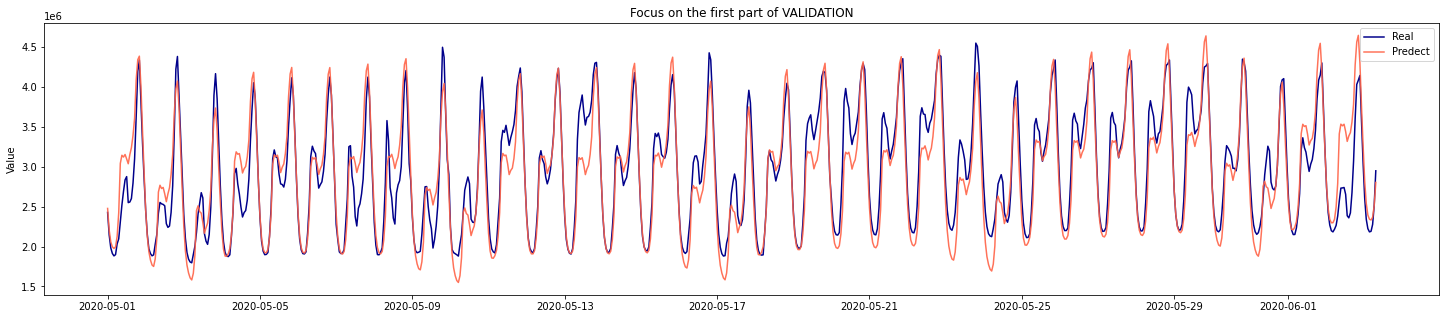

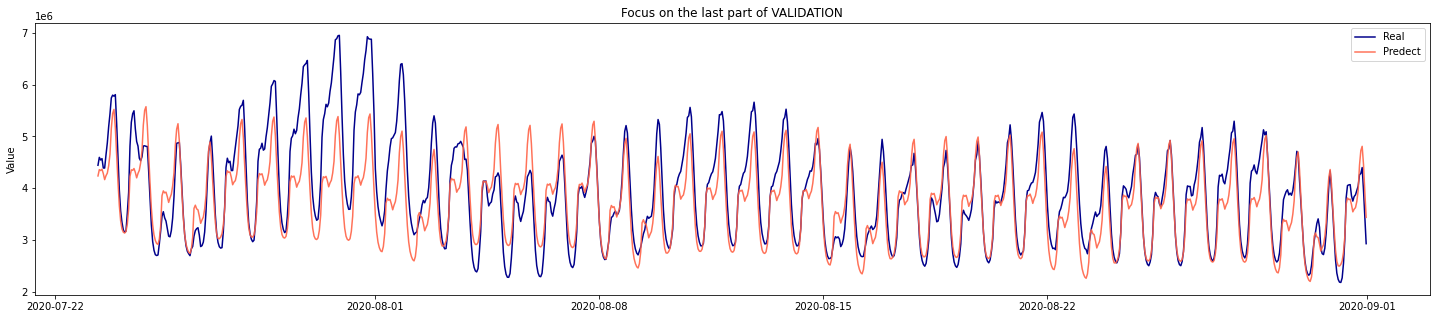

In [ ]:
plot_finale(train, validation, predicted_train_mean, predicted_val_mean, min)

In [ ]:
model = sm.tsa.statespace.SARIMAX(train['Value'],
                                  order=(3, 0, 3), seasonal_order=(1, 1, 1, 24),
                                  exog=x_train,
                                  enforce_stationarity=False, enforce_invertibility=False)
model = model.fit(disp=0, low_memory=True)

In [ ]:
print(model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                Value   No. Observations:                14592
Model:             SARIMAX(3, 0, 3)x(1, 1, [1], 24)   Log Likelihood             -188098.078
Date:                              Sat, 04 Sep 2021   AIC                         376258.156
Time:                                      10:26:16   BIC                         376493.280
Sample:                                  09-01-2018   HQIC                        376336.286
                                       - 04-30-2020                                         
Covariance Type:                             approx                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
sin(1,168)  -1.903e+05   1.72e+04    -11.068      0.000   -2.24e+05   -1.57e+05
cos(1,168)  -6.9

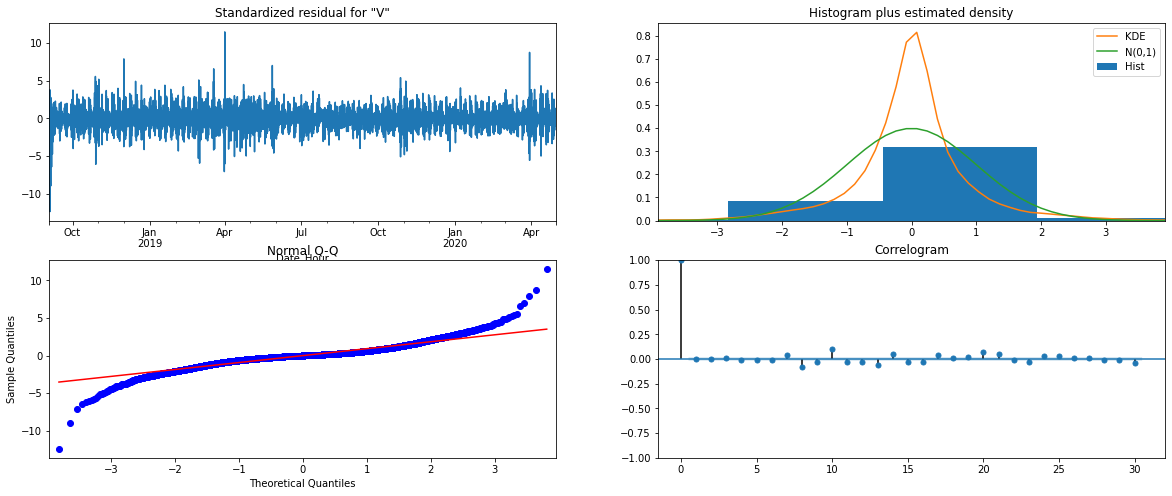

In [ ]:
fig = plt.figure(figsize=(20, 8))
fig = model.plot_diagnostics(fig=fig, lags=30)

### Previsioni

In [ ]:
#fourier's harmonics
four_sett = DeterministicProcess(pd.date_range(start="2018-09-01 00:00:00", end="2020-10-31 23:00:00", freq='H'),  period=168, fourier=6)
four_ann = DeterministicProcess(pd.date_range(start="2018-09-01 00:00:00", end="2020-10-31 23:00:00", freq='H'),  period=24*365.25, fourier=5)
four=four_sett.in_sample().merge( four_ann.in_sample(), left_index=True, right_index=True)

In [ ]:
x_data=four[:len(data)]
x_test=four[len(data):]

In [10]:
model_tot = sm.tsa.statespace.SARIMAX(data['Value'],
                                  order=(3, 0, 3), seasonal_order=(1, 1, 1, 24),
                                  exog=x_data,
                                  enforce_stationarity=False, enforce_invertibility=False)
model_tot = model_tot.fit(low_memory=True)

In [12]:
future = model_tot.get_prediction(start=pd.to_datetime('2020-09-01-0',  format = "%Y-%m-%d-%H"),
                              end=pd.to_datetime('2020-10-31-23',  format = "%Y-%m-%d-%H"),
                              exog=x_test)

In [13]:
forecast = pd.DataFrame({'ARIMA':future.predicted_mean, 
                         'Date':pd.date_range(start="2020-09-01 00:00:00", end="2020-10-31 23:00:00", freq='H')})

In [14]:
forecast.to_csv('ARIMA.csv')

## 2. UCM

Unobserved Components Model (UCM) decompone una serie storica univariata in diverse componenti trend, stagionali, cicliche, e irregolari. Ciascuna componente del modello cattura importanti caratteristiche della serie dinamica.

In [ ]:
#Mean Absolute Error 
def mean_absolute_error(y_true, y_pred): 
  return round(np.mean(np.abs(y_true - y_pred)), 1)

In [ ]:
def UCM_model(level_trend, train, validation):
  
  model = sm.tsa.UnobservedComponents(train['Value'],
                                      level_trend,
                                      seasonal=24, freq_seasonal = [{'period':24*7, 'harmonics':6}])
  model = model.fit(low_memory=True)
  
  # predict for evaluate on VALIDATION
  predicted_val = model.get_prediction(start=validation.index[0], end=validation.index[-1])
  predicted_val_mean = predicted_val.predicted_mean
  residui_val=validation['Value']-predicted_val_mean   
  
  min=model.loglikelihood_burn
  # predict for evaluate on TRAIN
  predicted_train = model.get_prediction(start=train.index[min], end=train.index[-1])
  predicted_train_mean = predicted_train.predicted_mean
  residui_train=train['Value'][min:]-predicted_train_mean

  print("level-trend: {}" .format(level_trend))
  print("MAE train:", mean_absolute_error(train['Value'][min:], predicted_train_mean))
  print("MAE validation:", mean_absolute_error(validation['Value'], predicted_val_mean), '\n')

In [ ]:
def plot_finale(train, validation, predicted_train_mean, predicted_val_mean, min):
  # prediction on TRAIN
  plt.figure(figsize=(25, 7))
  plt.title('Prediction on TRAIN')
  plt.plot(train['Value'][min:], color='dimgrey', label='Real')
  plt.plot(predicted_train_mean[min:], color='darkred', label='Predect', alpha=0.7)
  plt.ylabel('Value')
  plt.legend()
  plt.show()

  # prediction on TRAIN and VALIDATION
  plt.figure(figsize=(25, 5))
  plt.title('Prediction on TRAIN and VALIDATION')
  plt.plot(train['Value'], color='dimgrey', label='Train')
  plt.plot(validation['Value'], color='darkblue', label='Real')
  plt.plot(predicted_val_mean, color='tomato', label='Predect', alpha=0.7)
  plt.ylabel('Value')
  plt.legend()
  plt.show()

  # prediction on VALIDATION
  plt.figure(figsize=(25, 5))
  plt.title('Prediction on VALIDATION')
  plt.plot(validation['Value'], color='darkblue', label='Validation')
  plt.plot(predicted_val_mean, color='tomato', label='Predect', alpha=0.9)
  plt.ylabel('Value')
  plt.legend()
  plt.show()

  # figure on the first part of VALIDATION
  plt.figure(figsize=(25, 5))
  plt.title('Focus on the first part of VALIDATION')
  plt.plot(validation['Value'][:800], color='darkblue', label='Real')
  plt.plot(predicted_val_mean[:800], color='tomato', label='Predect', alpha=0.9)
  plt.ylabel('Value')
  plt.legend()
  plt.show()

  # figure on the last part of VALIDATION
  plt.figure(figsize=(25, 5))
  plt.title('Focus on the last part of VALIDATION')
  plt.plot(validation['Value'][2000:], color='darkblue', label='Real')
  plt.plot(predicted_val_mean[2000:], color='tomato', label='Predect', alpha=0.9)
  plt.ylabel('Value')
  plt.legend()
  plt.show()

Per capire quale è il migliore level trend uso diversi tipi di modelli quali il random walk, il random walk with drift, il local linear trend, il stochastic trend, il random trend, local level, local linear deterministic trend. 

In [ ]:
data=pd.read_csv('data_complete.csv', sep=',', header=0, low_memory=False, parse_dates=['Date_Hour'])
data.set_index('Date_Hour', inplace=True)
data.index.freq='H'

In [ ]:
train=data.loc[:"2020-04-30 23:00:00"]
validation=data.loc["2020-05-01 00:00:00":]

In [ ]:
for level_trend in ['rwalk', 'dconstant', 'ntrend', 'llevel', 'lldtrend', 'rwdrift', 'lltrend', 'strend', 'rtrend']:
  UCM_model(level_trend, train, validation)

level-trend: rwalk
MAE train: 136033.6
MAE validation: 782625.4 

level-trend: dconstant
MAE train: 600530.6
MAE validation: 3651114.1 

level-trend: ntrend
MAE train: 600509.3
MAE validation: 3651178.7 

level-trend: llevel
MAE train: 141739.8
MAE validation: 784019.9 

level-trend: lldtrend
MAE train: 141742.8
MAE validation: 775439.0 

level-trend: rwdrift
MAE train: 136033.5
MAE validation: 775391.1 

level-trend: lltrend
MAE train: 145298.4
MAE validation: 27220429.0 

level-trend: strend
MAE train: 145302.6
MAE validation: 27216492.4 

level-trend: rtrend
MAE train: 139492.4
MAE validation: 30142522.5 



In [ ]:
model = sm.tsa.UnobservedComponents(train['Value'],
                                    'rwdrift',
                                    seasonal=24, freq_seasonal = [{'period':24*7, 'harmonics':6}])
model = model.fit(low_memory=True)

In [ ]:
min=model.loglikelihood_burn
# predict for evaluate on TRAIN
predicted_train = model.get_prediction(start=train.index[min], end=train.index[-1])
predicted_train_mean = predicted_train.predicted_mean
residui_train=train['Value'][min:]-predicted_train_mean

# predict for evaluate on VALIDATION
predicted_val = model.get_prediction(start=validation.index[0], end=validation.index[-1])
predicted_val_mean = predicted_val.predicted_mean
residui_val=validation['Value']-predicted_val_mean

print("MAE train:", mean_absolute_error(train['Value'][min:], predicted_train_mean))
print("MAE validation:", mean_absolute_error(validation['Value'], predicted_val_mean))

MAE train: 136033.5
MAE validation: 775391.1


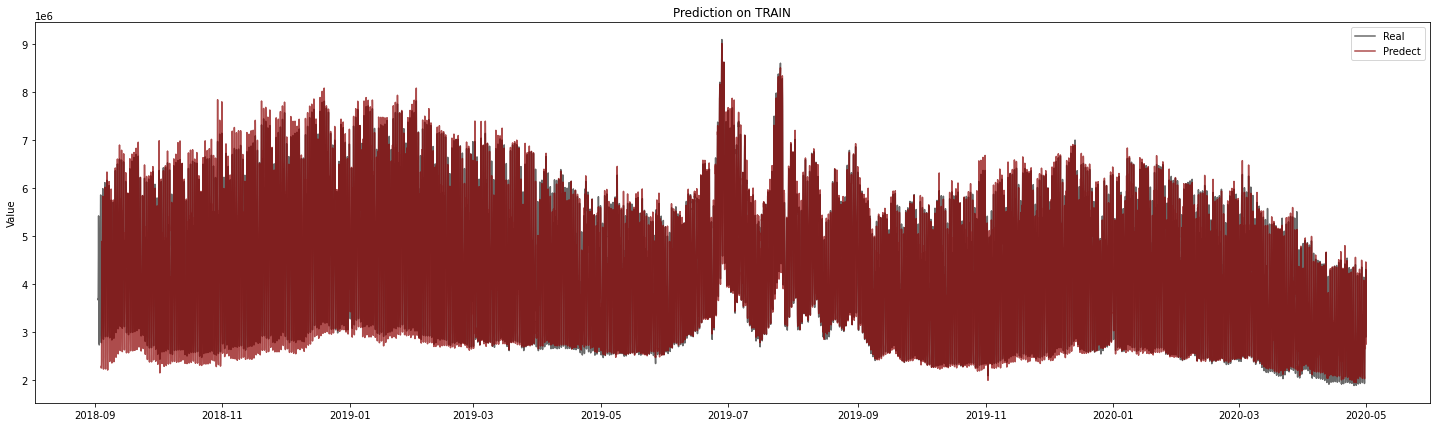

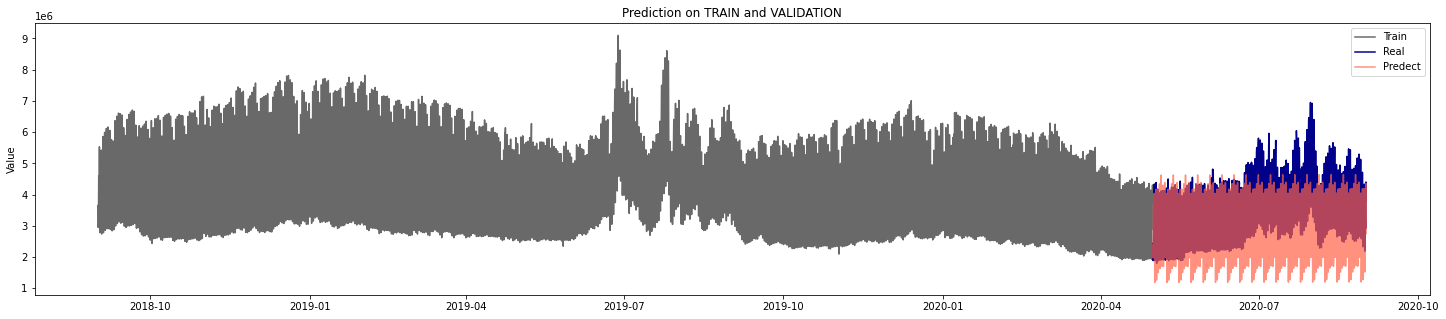

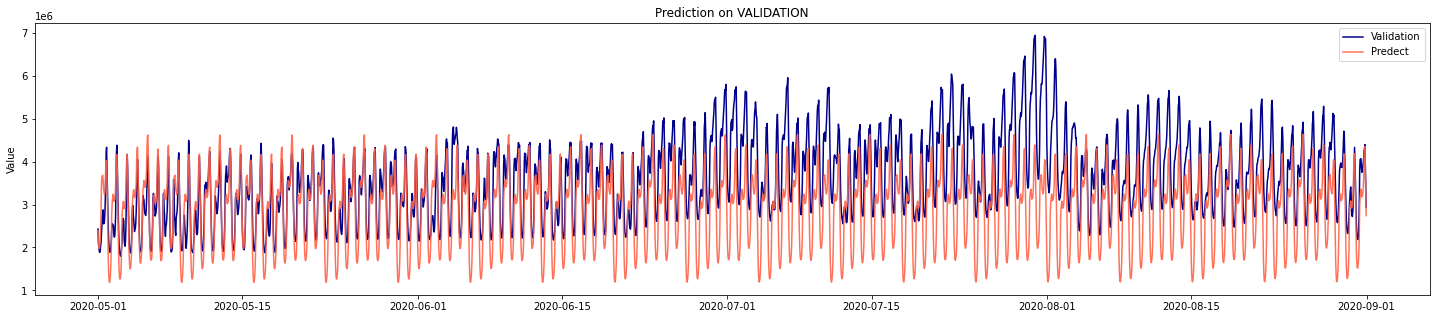

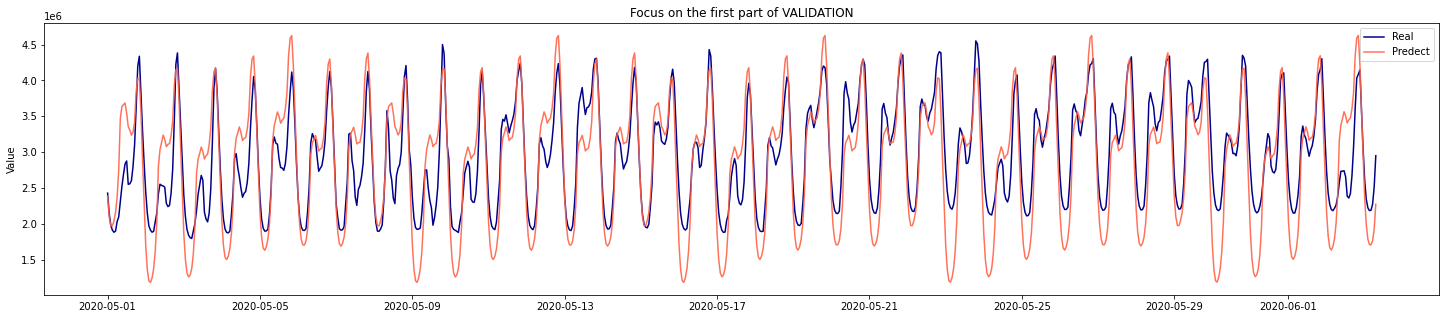

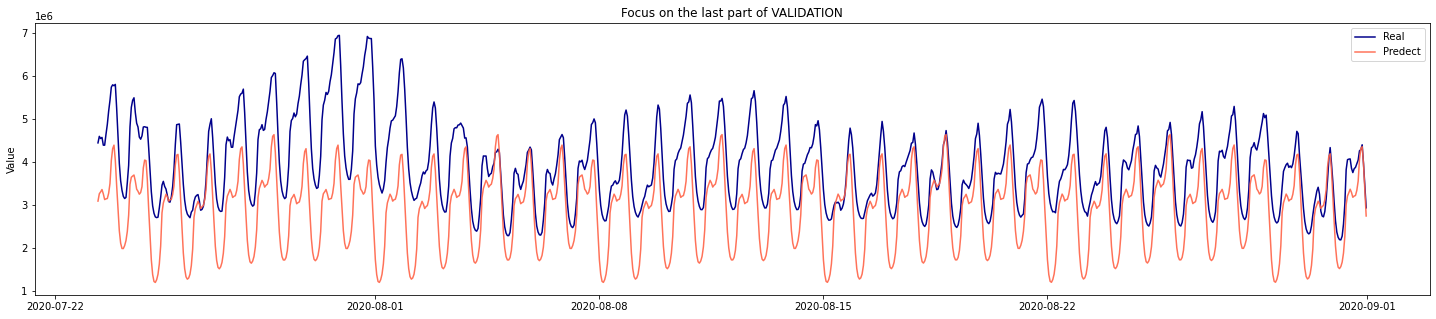

In [ ]:
plot_finale(train, validation, predicted_train_mean, predicted_val_mean, min)

###Previsioni

In [ ]:
model_tot = sm.tsa.UnobservedComponents(train['Value'],
                                    'rwdrift',
                                    seasonal=24, freq_seasonal = [{'period':24*7, 'harmonics':6}])
model_tot = model_tot.fit(low_memory=True)

In [ ]:
future = model_tot.get_prediction(start=pd.to_datetime('2020-09-01-0',  format = "%Y-%m-%d-%H"),
                                end=pd.to_datetime('2020-10-31-23',  format = "%Y-%m-%d-%H"))

In [ ]:
forecast = pd.DataFrame({'UCM':future.predicted_mean, 
                         'Date':pd.date_range(start="2020-09-01 00:00:00", end="2020-10-31 23:00:00", freq='H')})

In [ ]:
forecast.to_csv('UCM.csv')

## 3. PROPHET

Prophet è una libreria open source per previsioni di serie temporali univariate sviluppata da Facebook.

Prophet implementa un modello di previsione delle serie temporali additivo e l'implementazione supporta trend, stagionalità e festività ed è progettato per essere facile e completamente automatico.


In [55]:
#Mean Absolute Error 
def mean_absolute_error(y_true, y_pred): 
  return round(np.mean(np.abs(y_true - y_pred)), 1)

In [92]:
def plot_finale(train, validation, predicted_train_mean, predicted_val_mean):
  # prediction on TRAIN
  plt.figure(figsize=(25, 5))
  plt.title('Prediction on TRAIN')
  plt.plot(train['y'], color='dimgrey', label='Real')
  plt.plot(predicted_train_mean, color='darkred', label='Predect', alpha=0.7)
  plt.ylabel('y')
  plt.legend()
  plt.show()

  # prediction on TRAIN and VALIDATION
  plt.figure(figsize=(25, 5))
  plt.title('Prediction on TRAIN and VALIDATION')
  plt.plot(train['y'], color='dimgrey', label='Train')
  plt.plot(validation['y'], color='darkblue', label='Real')
  plt.plot(predicted_val_mean, color='tomato', label='Predect', alpha=0.7)
  plt.ylabel('y')
  plt.legend()
  plt.show()

  # prediction on VALIDATION
  plt.figure(figsize=(25, 5))
  plt.title('Prediction on VALIDATION')
  plt.plot(validation['y'], color='darkblue', label='Validation')
  plt.plot(predicted_val_mean, color='tomato', label='Predect', alpha=0.9)
  plt.ylabel('y')
  plt.legend()
  plt.show()

  # figure on the first part of VALIDATION
  plt.figure(figsize=(25, 5))
  plt.title('Focus on the first part of VALIDATION')
  plt.plot(validation['y'][:800], color='darkblue', label='Real')
  plt.plot(predicted_val_mean[:800], color='tomato', label='Predect', alpha=0.9)
  plt.ylabel('y')
  plt.legend()
  plt.show()

  # figure on the last part of VALIDATION
  plt.figure(figsize=(25, 5))
  plt.title('Focus on the last part of VALIDATION')
  plt.plot(validation['y'][-800:], color='darkblue', label='Real')
  plt.plot(predicted_val_mean[-800:], color='tomato', label='Predect', alpha=0.9)
  plt.ylabel('y')
  plt.legend()
  plt.show()

In [56]:
data=pd.read_csv('data_complete.csv', sep=',', header=0, low_memory=False, parse_dates=['Date_Hour'])
data.set_index('Date_Hour', inplace=True)
data.index.freq = 'H'

In [66]:
#The fit() function takes a DataFrame of time series data. The DataFrame must have a specific format. 
#The first column must have the name 'ds' and contain the date-times. The second column must have the name 'y' and contain the observations.
data['ds'] = data.index
data.rename(columns={"Value": "y",}, inplace=True)

In [68]:
#Train / validation split
train=data[data['ds']<="2020-04-30 23:00:00"]
validation=data[data['ds']>"2020-04-30 23:00:00"]

In [70]:
model = Prophet(yearly_seasonality=True, changepoint_prior_scale=0.01, seasonality_prior_scale=0.01)

# fit the model
model.fit(train)

In [71]:
# parameter of model seasonalities 
model.seasonalities

OrderedDict([('yearly',
              {'condition_name': None,
               'fourier_order': 10,
               'mode': 'additive',
               'period': 365.25,
               'prior_scale': 0.01}),
             ('weekly',
              {'condition_name': None,
               'fourier_order': 3,
               'mode': 'additive',
               'period': 7,
               'prior_scale': 0.01}),
             ('daily',
              {'condition_name': None,
               'fourier_order': 4,
               'mode': 'additive',
               'period': 1,
               'prior_scale': 0.01})])

In [78]:
in_sample_forecast = model.predict(train[['ds']])
out_sample_forecast = model.predict(validation[['ds']])

In [86]:
print("MAE train:", mean_absolute_error(train['y'].reset_index(drop=True), in_sample_forecast['yhat']))
print("MAE validation:", mean_absolute_error(validation['y'].reset_index(drop=True), out_sample_forecast['yhat']))

MAE train: 367604.6
MAE validation: 597051.0


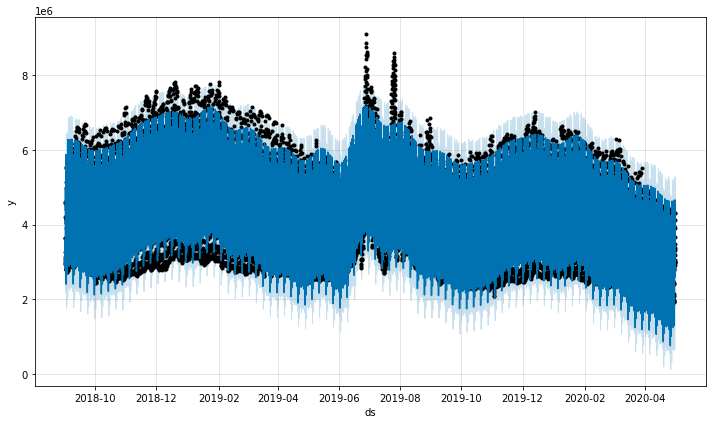

In [87]:
fig1= model.plot(in_sample_forecast)

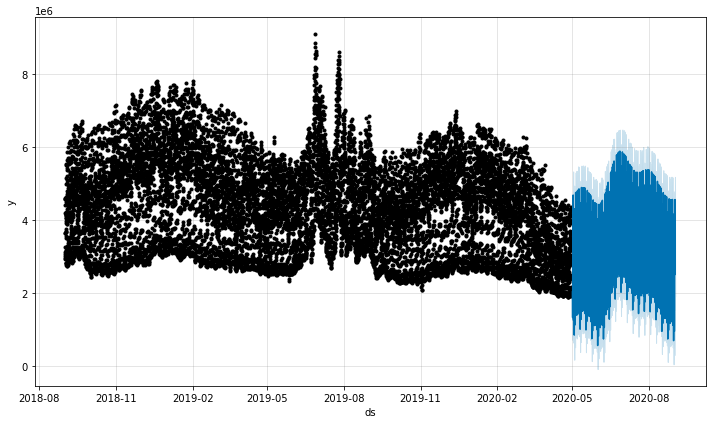

In [88]:
fig2=model.plot(out_sample_forecast)

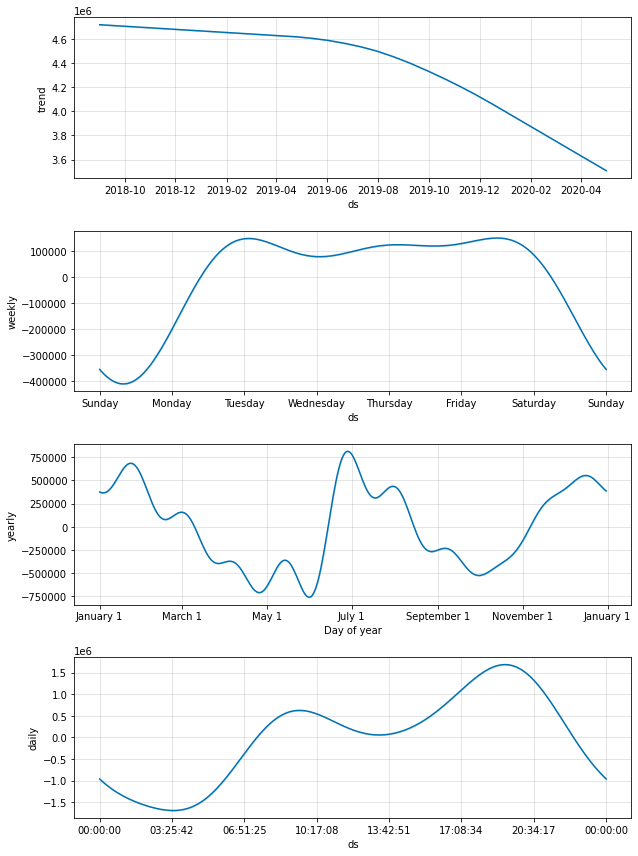

In [89]:
fig3 = model.plot_components(in_sample_forecast)

In [90]:
in_sample_forecast.set_index('ds', inplace=True)
out_sample_forecast.set_index('ds', inplace=True)
train.set_index('ds', inplace=True)
validation.set_index('ds', inplace=True)

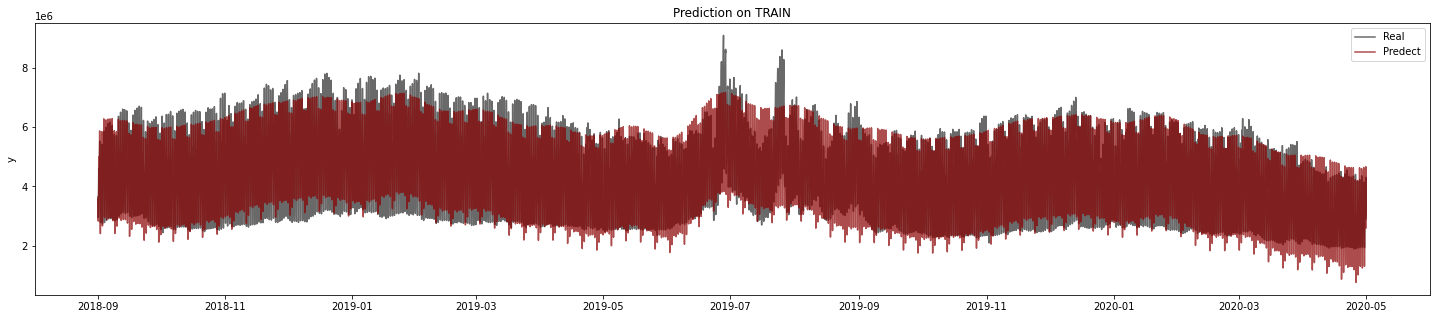

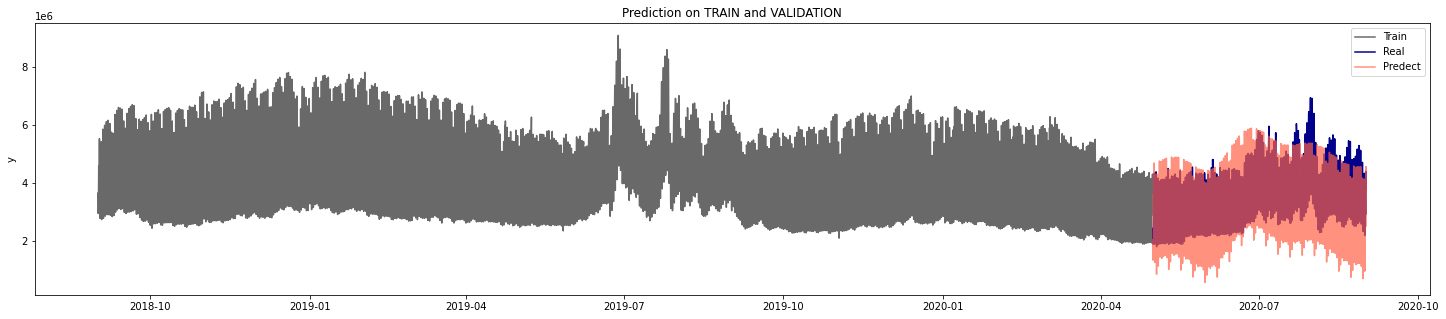

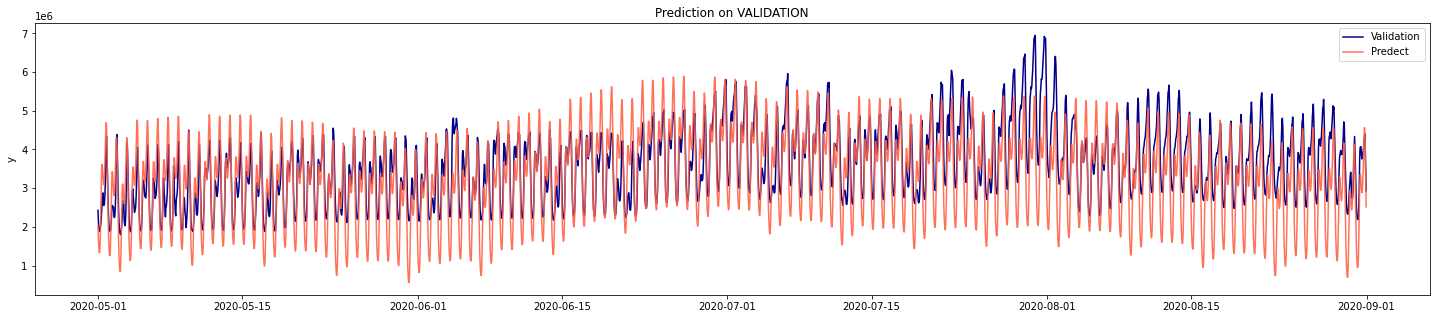

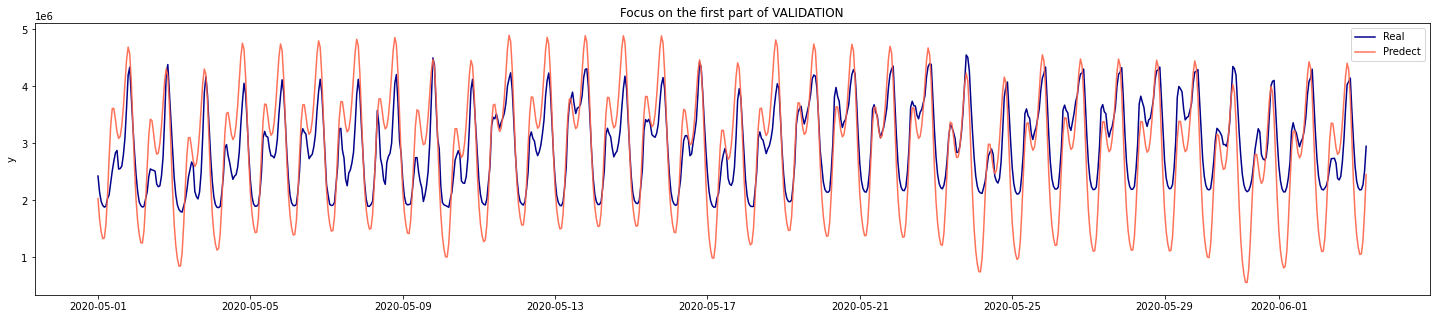

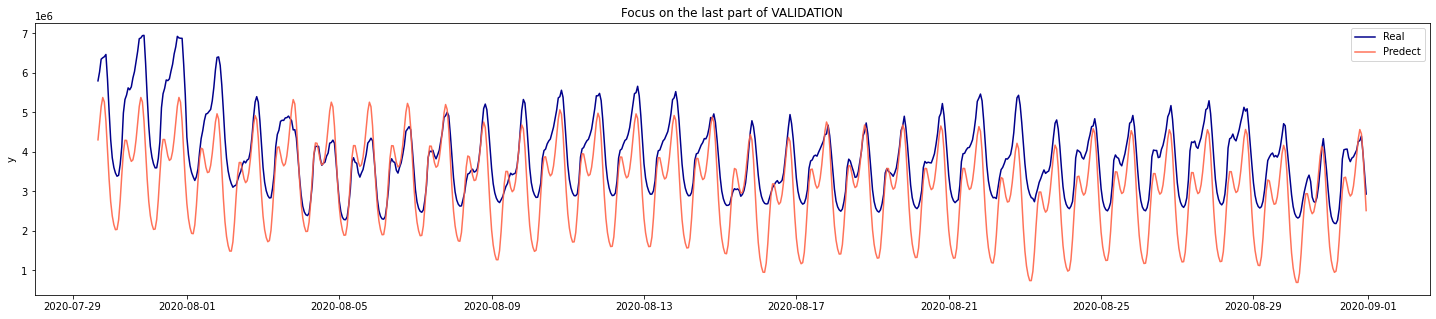

In [93]:
plot_finale(train, validation, in_sample_forecast['yhat'], out_sample_forecast['yhat'])

### Tuning degli iperparametri
Il modello Prophet ha una serie di ipeparametri di input che si potrebbero ottimizzare. Utilizzo la cross-validazione per ottimizzare gli iperparametri del modello, changepoint_prior_scale e seasonality_prior_scale.

In [94]:
train.reset_index(inplace=True)
validation.reset_index(inplace=True)

In [95]:
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
maes = []  # Store the MAEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(yearly_seasonality=True, **params).fit(data)  # Fit model with given params
    df_cv = cross_validation(m, initial = '366 days', period='100 days', horizon='61 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    maes.append(df_p['mae'].values[0])

INFO:fbprophet:Making 4 forecasts with cutoffs between 2019-09-05 23:00:00 and 2020-07-01 23:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fcf09bdd550>
INFO:fbprophet:Making 4 forecasts with cutoffs between 2019-09-05 23:00:00 and 2020-07-01 23:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fcf09bdd550>
INFO:fbprophet:Making 4 forecasts with cutoffs between 2019-09-05 23:00:00 and 2020-07-01 23:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fceac357a10>
INFO:fbprophet:Making 4 forecasts with cutoffs between 2019-09-05 23:00:00 and 2020-07-01 23:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fceb1130990>
INFO:fbprophet:Making 4 forecasts with cutoffs between 2019-09-05 23:00:00 and 2020-07-01 23:00:00
INFO:fbprophet:Applying in parallel with <con

In [96]:
# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['mae'] = maes
print(tuning_results)

    changepoint_prior_scale  seasonality_prior_scale           mae
0                     0.001                     0.01  6.339808e+05
1                     0.001                     0.10  6.362237e+05
2                     0.001                     1.00  6.373488e+05
3                     0.001                    10.00  6.385592e+05
4                     0.010                     0.01  6.124614e+05
5                     0.010                     0.10  6.195209e+05
6                     0.010                     1.00  6.253807e+05
7                     0.010                    10.00  6.260033e+05
8                     0.100                     0.01  6.598480e+05
9                     0.100                     0.10  9.969284e+05
10                    0.100                     1.00  8.521927e+05
11                    0.100                    10.00  7.358069e+05
12                    0.500                     0.01  1.061018e+06
13                    0.500                     0.10  2.946970

In [97]:
best_params = all_params[np.argmin(maes)]
print(best_params)

{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}


### Previsioni

In [98]:
model_tot = Prophet(yearly_seasonality=True, changepoint_prior_scale=0.01, 
                                             seasonality_prior_scale=0.01)

# fit the model
model_tot.fit(data)

In [99]:
future = model_tot.make_future_dataframe(periods=61*24,  freq='H', include_history=False)

In [100]:
forecast = model_tot.predict(future)
#forecast.columns

In [101]:
forecast = model_tot.predict(future)
forecast=forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

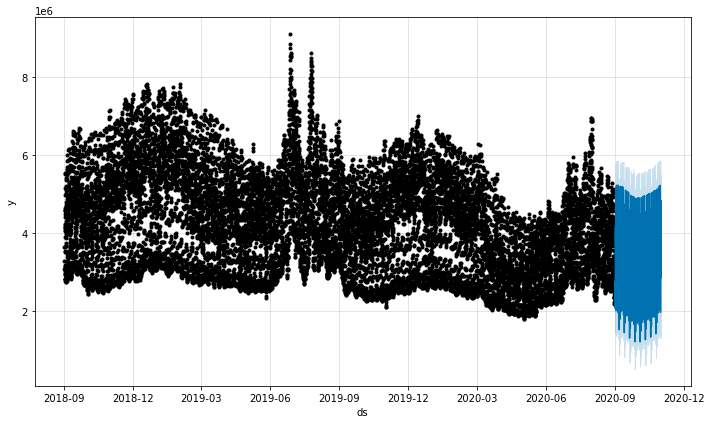

In [102]:
fig4=model_tot.plot(forecast)

In [103]:
forecast.drop(['yhat_lower', 'yhat_upper'], axis='columns', inplace=True)
forecast.rename(columns={"ds": "Date", "yhat": "prophet"}, inplace=True)
forecast.to_csv('prophet.csv')

## 4. Machine Learning

In [5]:
#Mean Absolute Error
def mean_absolute_error(y_true, y_pred): 
  return round(np.mean(np.abs(y_true - y_pred)), 1)

In [6]:
def plot_finale(train, validation, predicted_val_mean):

  # prediction on TRAIN and VALIDATION
  plt.figure(figsize=(25, 5))
  plt.title('Prediction on TRAIN and VALIDATION')
  plt.plot(train['Value'], color='dimgrey', label='Train')
  plt.plot(validation['Value'], color='darkblue', label='Real')
  plt.plot(predicted_val_mean, color='tomato', label='Predect', alpha=0.7)
  plt.ylabel('Value')
  plt.legend()
  plt.show()

  # prediction on VALIDATION
  plt.figure(figsize=(25, 5))
  plt.title('Prediction on VALIDATION')
  plt.plot(validation['Value'], color='darkblue', label='Validation')
  plt.plot(predicted_val_mean, color='tomato', label='Predect')
  plt.ylabel('Value')
  plt.legend()
  plt.show()

  # figure on the first part of VALIDATION
  plt.figure(figsize=(25, 5))
  plt.title('Focus on the first part of VALIDATION')
  plt.plot(validation['Value'][:800], color='darkblue', label='Real')
  plt.plot(predicted_val_mean[:800], color='tomato', label='Predect')
  plt.ylabel('Value')
  plt.legend()
  plt.show()

  # figure on the last part of VALIDATION
  plt.figure(figsize=(25, 5))
  plt.title('Focus on the last part of VALIDATION')
  plt.plot(validation['Value'][-800:], color='darkblue', label='Real')
  plt.plot(predicted_val_mean[-800:], color='tomato', label='Predect')
  plt.ylabel('Value')
  plt.legend()
  plt.show()

In [7]:
#function that splits the data into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
  X, y = list(), list()
  for i in range(len(sequence)):
    # find the end of this pattern
    end_ix = i + n_steps_in
    out_end_ix = end_ix + n_steps_out
    # check if we are beyond the sequence
    if out_end_ix > len(sequence):
      break
    # gather input and output parts of the pattern
    seq_x, seq_y = list(sequence[i:end_ix]), list(sequence[end_ix:out_end_ix])
    X.append(seq_x)
    y.append(seq_y)
  return np.array(X), np.array(y)

In [8]:
def preprocess_data(X, scaler=None):
    """Preprocess input data by standardise features"""
    if not scaler:
        scaler = MinMaxScaler(feature_range=(0.01, 1))
        scaler.fit(X)
    X = scaler.transform(X)
    return X, scaler

In [9]:
def data_preparation(n_steps_in, n_steps_out, train_st, n_features=1):
  # split into samples
  X, y = split_sequence(train_st, n_steps_in, n_steps_out)
  # reshape from [samples, timesteps] into [samples, timesteps, features]
  X = X.reshape((X.shape[0], X.shape[1], n_features))
  return X, y

In [10]:
data=pd.read_csv('data_complete.csv', sep=',', header=0, low_memory=False, parse_dates=['Date_Hour'])
data.set_index('Date_Hour', inplace=True)
data.index.freq = 'H'

In [11]:
#Train / validation split
train = data.loc[:"2020-04-30 23:00:00"]
validation = data.loc["2020-05-01 00:00:00":]

train_scaled = data.loc[:"2020-04-30 23:00:00"].copy()
train_scaled, scaler = preprocess_data(train_scaled)

data_scaled = data.copy()
data_scaled, data_scaler = preprocess_data(data_scaled)

Prima di procedere con l'utilizzo dei modelli di Machine Learning, è buona pratica applicare una normalizzazione dei dati che porta ad un miglioramento delle performance delle Neural Networks. 


1.   Fit MinMaxScaler usando il training data
2.   Applicare lo scaler al training data
3.   Applicare lo scaler al validation data



Per effettuare le previsioni due mesi avanti della serie storica, diversi possibili due approcci: 


1.   Previsione con modello ricorsivo: le previsioni per gli step successivi al primo si ottengono in modo ricorsivo utilizzando le previsioni effettuate fino a quel punto per quelle future. 
2.   Multi-output: il modello prevede direttamente tutto l'intervallo di previsione.
3.   Previsione ibrida: il vettore di output ha più dimensioni ma il modello prevede l'intero intervallo di previsione in modo ricorsivo. 

Per questioni di RAM ho affrontato la prima e terza tipologia di previsione. 



## Metodo ricorsivo
### Modelli LSTM

Un modello LSTM richiede un dato con dimensione [samples, timesteps, features]. Il primo modello sviluppato contiene un unico hidden layer LSTM contente 200 unità.

In [ ]:
n_steps_in, n_steps_out = 24, 1
X, y = data_preparation(n_steps_in, n_steps_out, train_scaled)
n_features = 1

Dalla data preparation, 15312 campioni sono stati creati a partire dai dati di training: l'array X contiene 15312 campioni di lunghezza 24 e l'array y 15312 campioni di lunghezza 1. Il modello prende impasto un campione di 24 timestep e si allena a prendire lo step successivo. 

In [ ]:
print(X.shape)
print(y.shape)

(14568, 24, 1)
(14568, 1, 1)


Il modello LSTM è stato implementato con la modalità stateful per tenere memoria tra i batch in un epoca di addestramento. È stato implementato un batch_size = 1. 

In [ ]:
batch_size = 1

model = Sequential()
# Input layer
model.add(LSTM(units = 200, batch_input_shape=(batch_size, n_steps_in, n_features), stateful=True))
model.add(Dropout(0.2)) 
model.add(Dense(n_steps_out)) 
# Compile model
model.compile(optimizer='adam',loss='mae')

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (1, 200)                  161600    
_________________________________________________________________
dropout_1 (Dropout)          (1, 200)                  0         
_________________________________________________________________
dense_1 (Dense)              (1, 1)                    201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________


In [ ]:
for i in range(4):
	model.fit(X, y, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
	model.reset_states()

14568/14568 [==============================] - 254s 17ms/step - loss: 0.0196


In [ ]:
#prediction on validation set
prev_st=[]
x_input = np.array(train_scaled[-n_steps_in:])
for i in range(len(validation)):
  x_input = x_input[-n_steps_in:]
  yhat = model.predict(x_input.reshape(1, n_steps_in, n_features), verbose=0, batch_size=batch_size)
  prev_st.append(yhat[0][0])
  x_input=np.vstack([x_input, yhat[0]])
  del yhat

In [ ]:
prev = scaler.inverse_transform(np.array(prev_st).reshape(-1,1))
pred_final = pd.DataFrame(prev, index=validation.index, columns=['Value'])

In [ ]:
#performance of the model
_, y = data_preparation(n_steps_in, n_steps_out, train['Value'])
print("MAE train: ", mean_absolute_error(scaler.inverse_transform(model.predict(X, batch_size=batch_size)), y))
print("MAE validation: ", mean_absolute_error(validation['Value'], pred_final['Value']))

MAE train:  761781.4
MAE validation:  877092.5


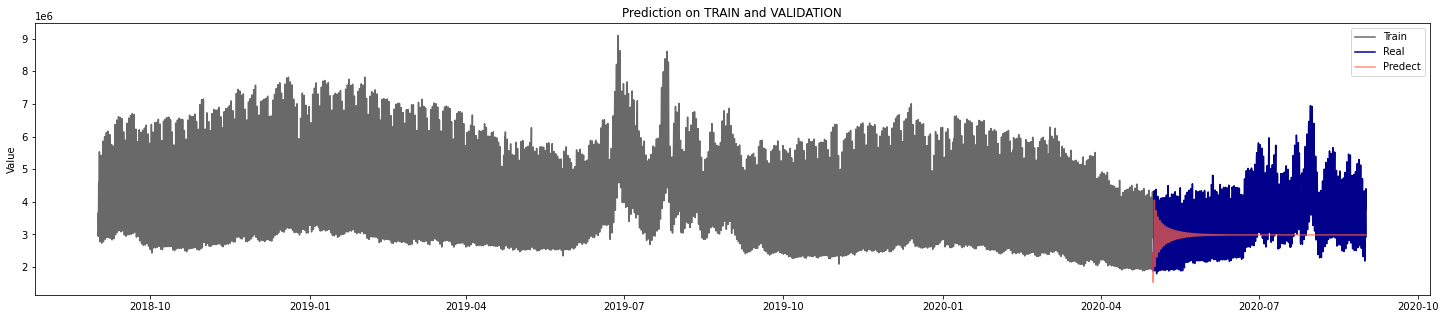

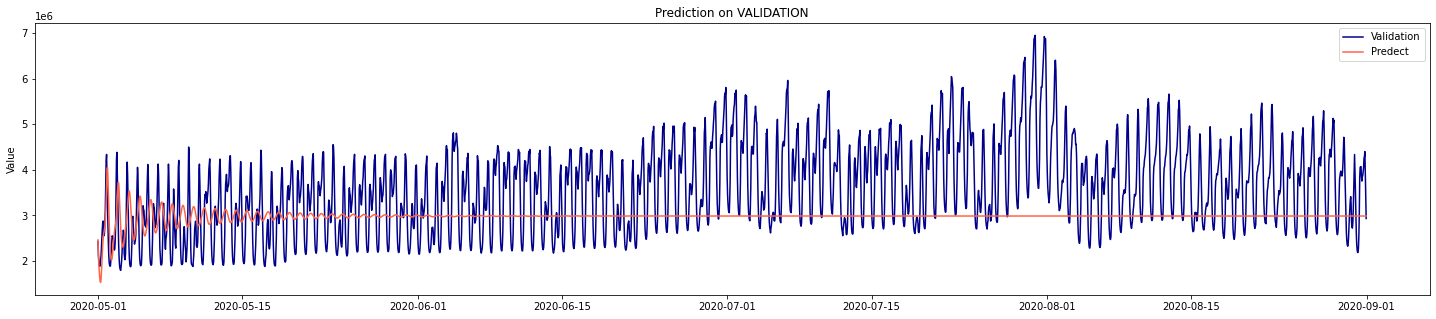

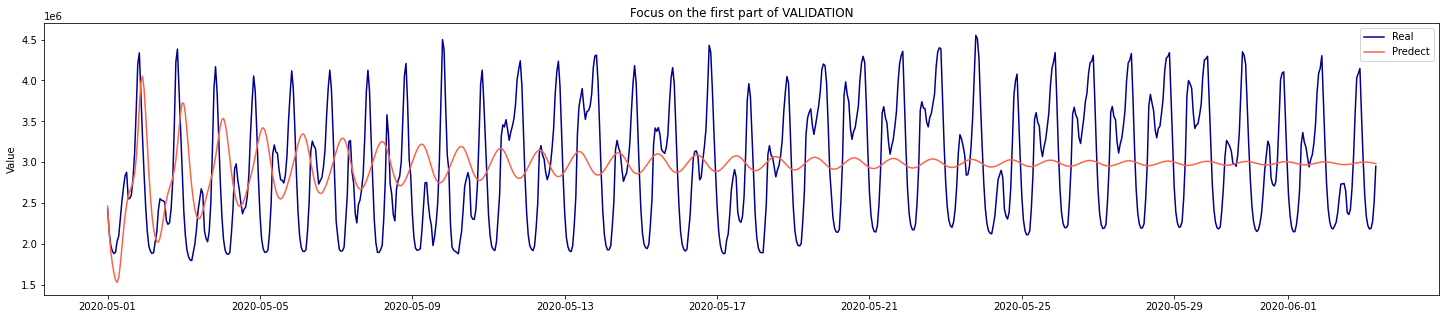

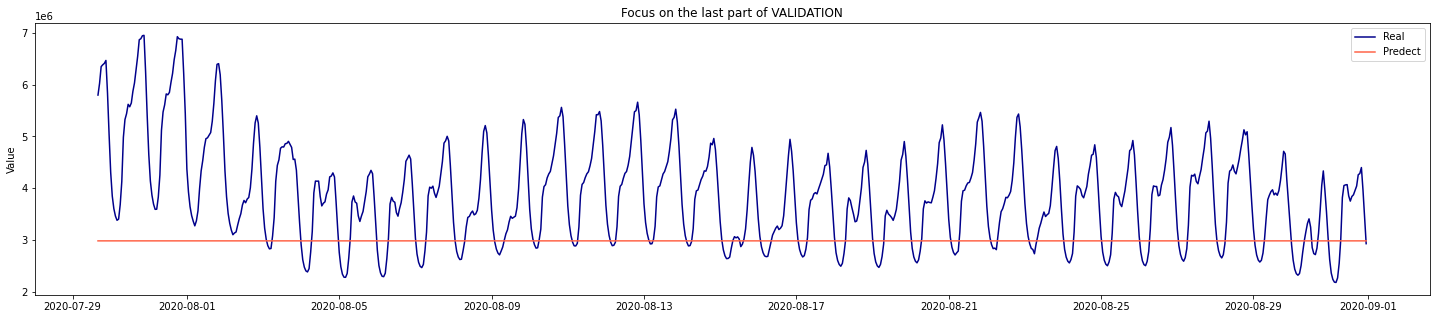

In [ ]:
plot_finale(train, validation, pred_final['Value'])
del model

In [ ]:
#Train / validation split
train = data.loc[:"2020-04-30 23:00:00"]
validation = data.loc["2020-05-01 00:00:00":]

train_scaled = data.loc[:"2020-04-30 23:00:00"].copy()
train_scaled, scaler = preprocess_data(train_scaled)

data_scaled = data.copy()
data_scaled, data_scaler = preprocess_data(data_scaled)

In [ ]:
n_steps_in, n_steps_out = 24, 1
X, y = data_preparation(n_steps_in, n_steps_out, train_scaled)
n_features = 1

In [ ]:
batch_size = 1

model = Sequential()
# Input layer
model.add(LSTM(units = 200, batch_input_shape=(batch_size, n_steps_in, n_features), stateful=True))
model.add(LeakyReLU())
model.add(Dropout(0.2)) 
model.add(Dense(n_steps_out)) 
# Compile model
model.compile(optimizer='adam',loss='mae')

In [ ]:
for i in range(4):
	model.fit(X, y, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
	model.reset_states()

14568/14568 [==============================] - 163s 11ms/step - loss: 0.0197


In [ ]:
#model.fit(X, y, epochs=4, batch_size=batch_size, verbose=1, shuffle=False)

In [ ]:
#prediction on validation set
prev_st=[]
x_input = np.array(train_scaled[-n_steps_in:])
for i in range(len(validation)):
  x_input = x_input[-n_steps_in:]
  yhat = model.predict(x_input.reshape(1, n_steps_in, n_features), verbose=0, batch_size=batch_size)
  prev_st.append(yhat[0][0])
  x_input=np.vstack([x_input, yhat[0]])
  del yhat

In [ ]:
prev = scaler.inverse_transform(np.array(prev_st).reshape(-1,1))
pred_final = pd.DataFrame(prev, index=validation.index, columns=['Value'])

In [ ]:
#performance of the model
_, y = data_preparation(n_steps_in, n_steps_out, train['Value'])
print("MAE train: ", mean_absolute_error(scaler.inverse_transform(model.predict(X, batch_size=batch_size)), y))
print("MAE validation: ", mean_absolute_error(validation['Value'], pred_final['Value']))

MAE train:  569795.6
MAE validation:  945021.9


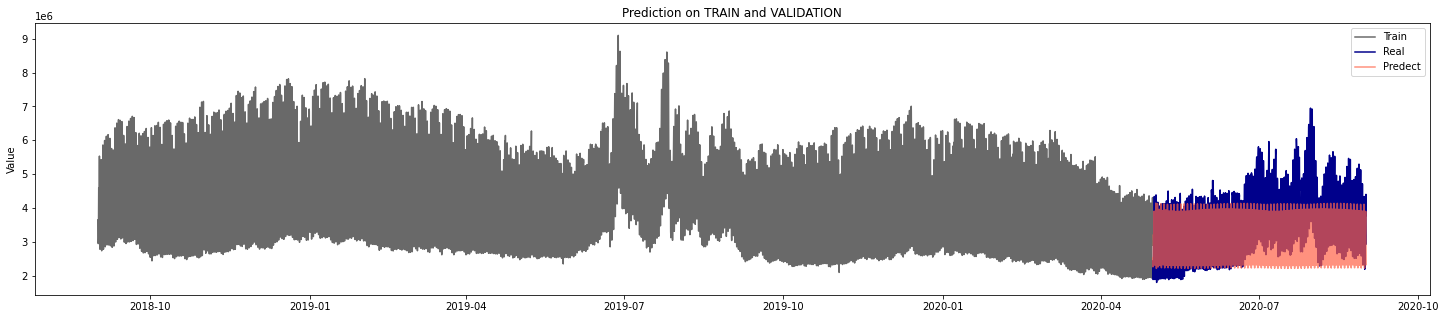

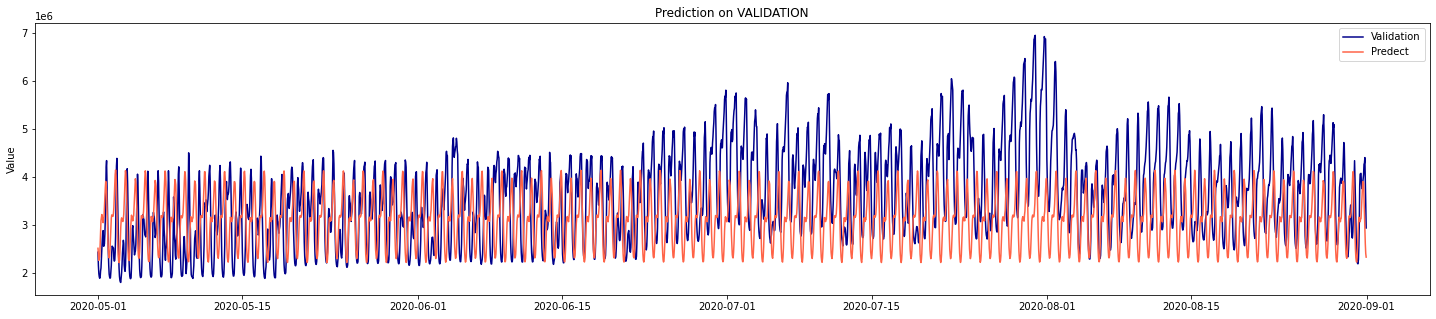

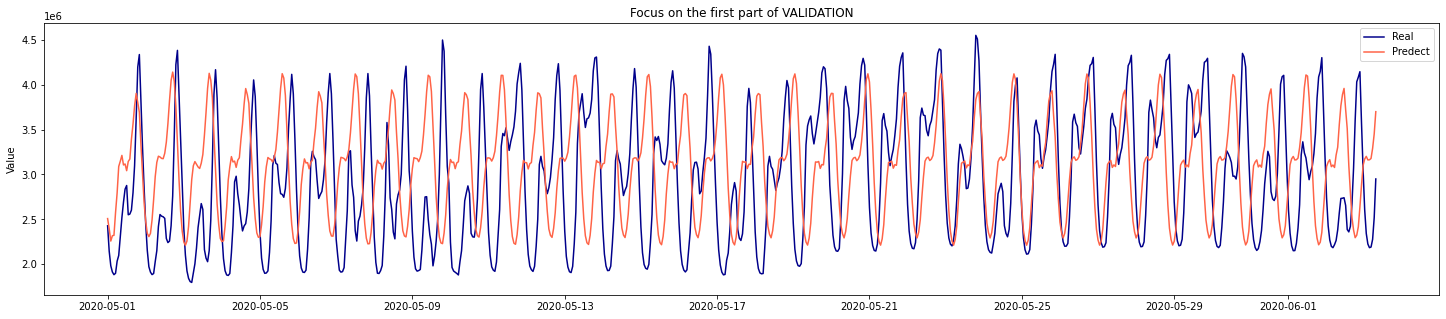

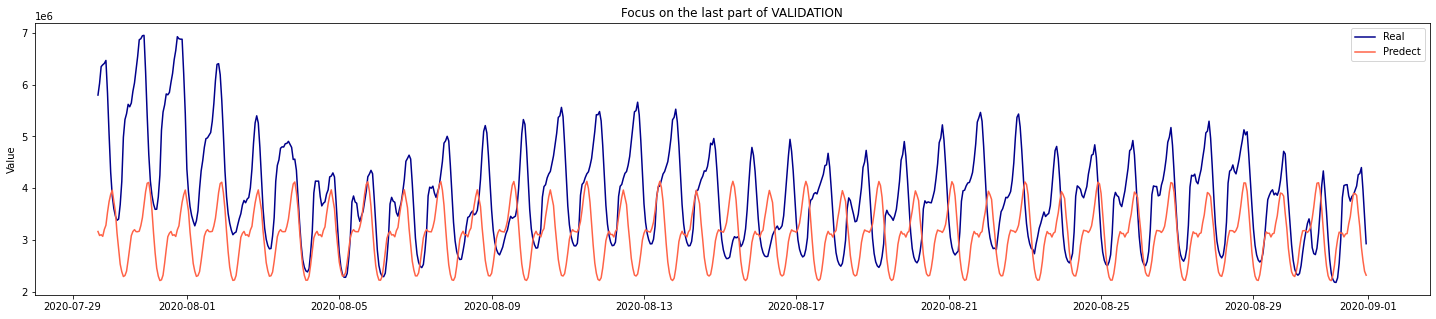

In [ ]:
plot_finale(train, validation, pred_final['Value'])
del model

In [43]:
#Train / validation split
train = data.loc[:"2020-04-30 23:00:00"]
validation = data.loc["2020-05-01 00:00:00":]

train_scaled = data.loc[:"2020-04-30 23:00:00"].copy()
train_scaled, scaler = preprocess_data(train_scaled)

data_scaled = data.copy()
data_scaled, data_scaler = preprocess_data(data_scaled)

In [44]:
n_steps_in, n_steps_out = 24, 1
X, y = data_preparation(n_steps_in, n_steps_out, train_scaled)
n_features = 1

In [45]:
batch_size = 1

model = Sequential()
# Input layer
model.add(GRU(units = 200, batch_input_shape=(batch_size, n_steps_in, n_features), stateful=True))
model.add(LeakyReLU())
model.add(Dropout(0.2)) 
model.add(Dense(n_steps_out)) 
# Compile model
model.compile(optimizer='adam',loss='mae')

In [46]:
for i in range(4):
	model.fit(X, y, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
	model.reset_states()

14568/14568 [==============================] - 210s 14ms/step - loss: 0.0213


In [ ]:
#model.fit(X, y, epochs=4, batch_size=batch_size, verbose=1, shuffle=False)

In [49]:
#prediction on validation set
prev_st=[]
x_input = np.array(train_scaled[-n_steps_in:])
for i in range(len(validation)):
  x_input = x_input[-n_steps_in:]
  yhat = model.predict(x_input.reshape(1, n_steps_in, n_features), verbose=0, batch_size=batch_size)
  prev_st.append(yhat[0][0])
  x_input=np.vstack([x_input, yhat[0]])
  #print(x_input.shape)
  del yhat

In [ ]:
prev = scaler.inverse_transform(np.array(prev_st).reshape(-1,1))
pred_final = pd.DataFrame(prev, index=validation.index, columns=['Value'])

In [ ]:
#performance of the model
_, y = data_preparation(n_steps_in, n_steps_out, train['Value'])
print("MAE train: ", mean_absolute_error(scaler.inverse_transform(model.predict(X, batch_size=batch_size)), y))
print("MAE validation: ", mean_absolute_error(validation['Value'], pred_final['Value']))

MAE train:  742848.6
MAE validation:  1030330.9


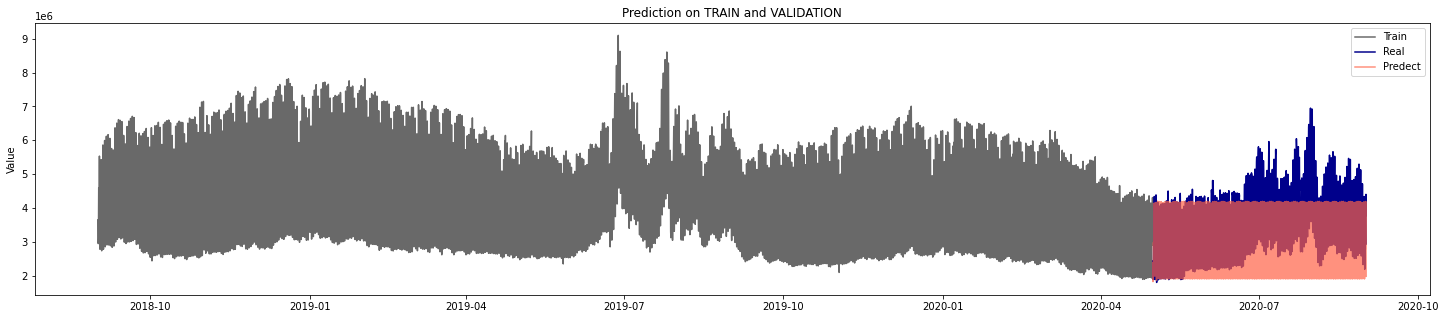

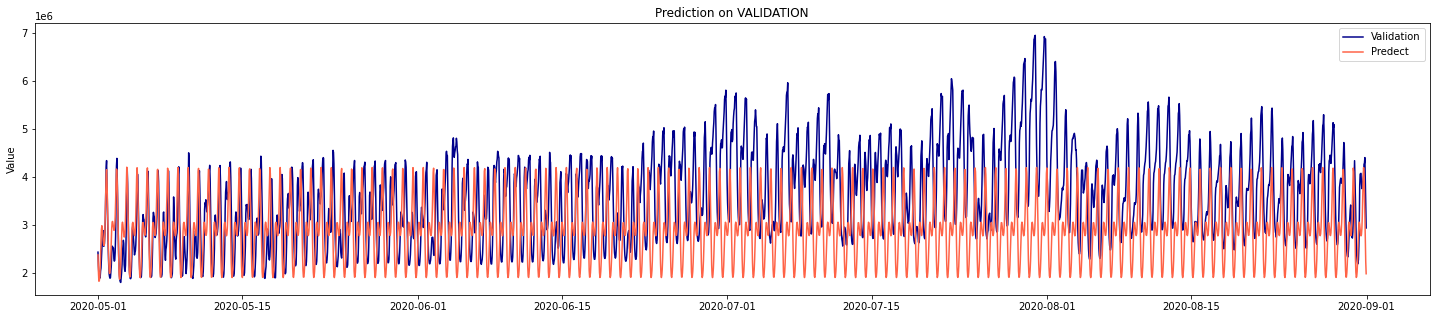

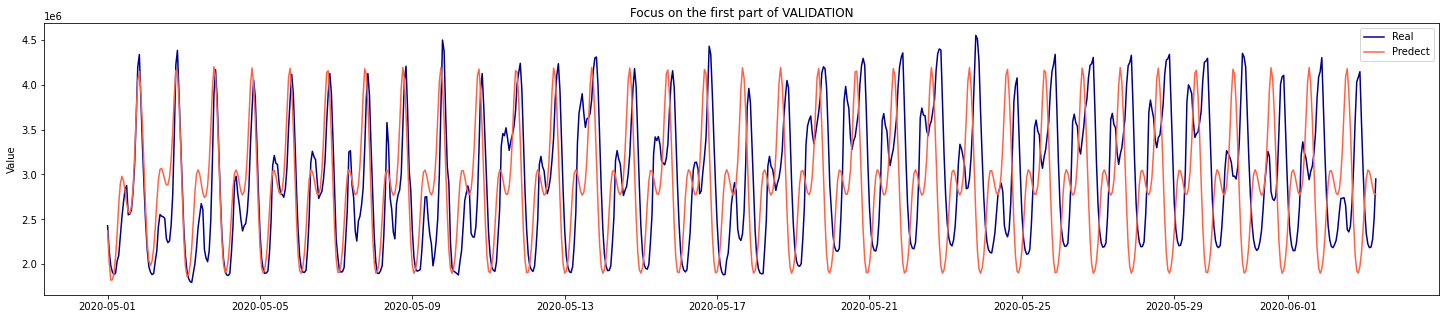

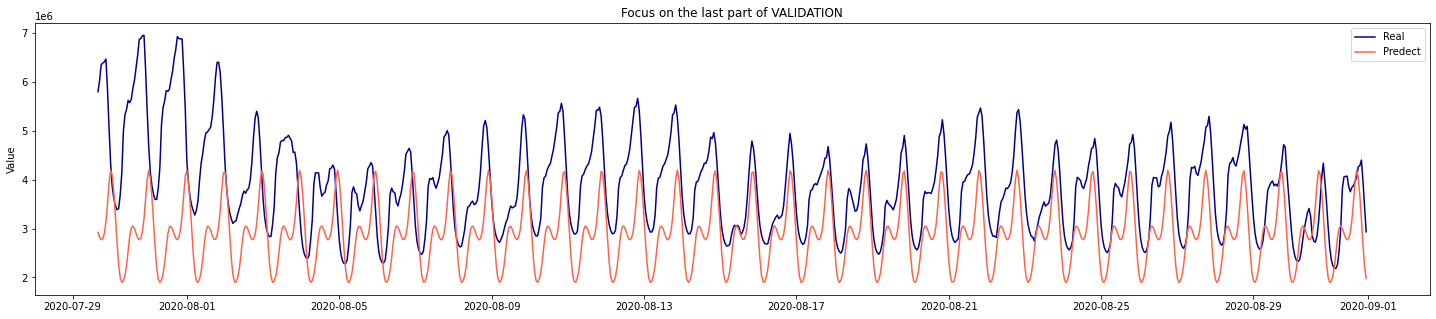

In [ ]:
plot_finale(train, validation, pred_final['Value'])
del model

## Hybrid prediction - vector output model
### Modello LSTM - 1 day prediction

In [25]:
#Train / validation split
train = data.loc[:"2020-04-30 23:00:00"]
validation = data.loc["2020-05-01 00:00:00":]

train_scaled = data.loc[:"2020-04-30 23:00:00"].copy()
train_scaled, scaler = preprocess_data(train_scaled)

data_scaled = data.copy()
data_scaled, data_scaler = preprocess_data(data_scaled)

In [23]:
n_features = 1
n_steps_in, n_steps_out= 24, 24
X, y = data_preparation(n_steps_in, n_steps_out, train_scaled)

In [12]:
batch_size = 1

#define model
model = Sequential()
model.add(LSTM(200, batch_input_shape=(batch_size, n_steps_in, n_features), stateful=True)) 
model.add(LeakyReLU())
model.add(Dropout(0.2))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mae')
#model.summary()

for i in range(3):
	model.fit(X, y, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
	model.reset_states()

14545/14545 [==============================] - 74s 5ms/step - loss: 0.0421


In [13]:
#prediction on validation set
prev_st=[]
x_input = np.array(train_scaled[-n_steps_in:])
for i in range(int(len(validation)/n_steps_out)+1):
  x_input = x_input[-n_steps_in:]
  yhat = model.predict(x_input.reshape(1, n_steps_in, n_features), verbose=0, batch_size=batch_size)
  for j in range(n_steps_out):
    prev_st.append(yhat[0][j])
  x_input=np.vstack([x_input, yhat[0].reshape(yhat[0].shape[0], 1)])
  del yhat

In [15]:
prev = scaler.inverse_transform(np.array(prev_st).reshape(-1,1))
pred_final = pd.DataFrame(prev[:len(validation)], index=validation.index, columns=['Value'])

In [27]:
#performance of the model
_, y = data_preparation(n_steps_in, n_steps_out, train['Value'])
print("MAE train:", mean_absolute_error(scaler.inverse_transform(model.predict(X, batch_size=batch_size)), y))
print("MAE validation:", mean_absolute_error(validation['Value'], pred_final['Value']))

MAE train: 1388386.7
MAE validation: 868125.8


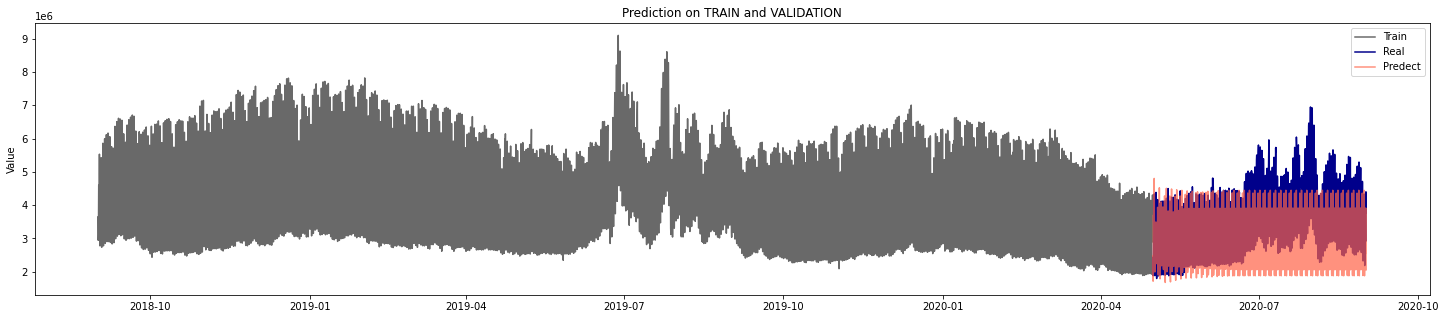

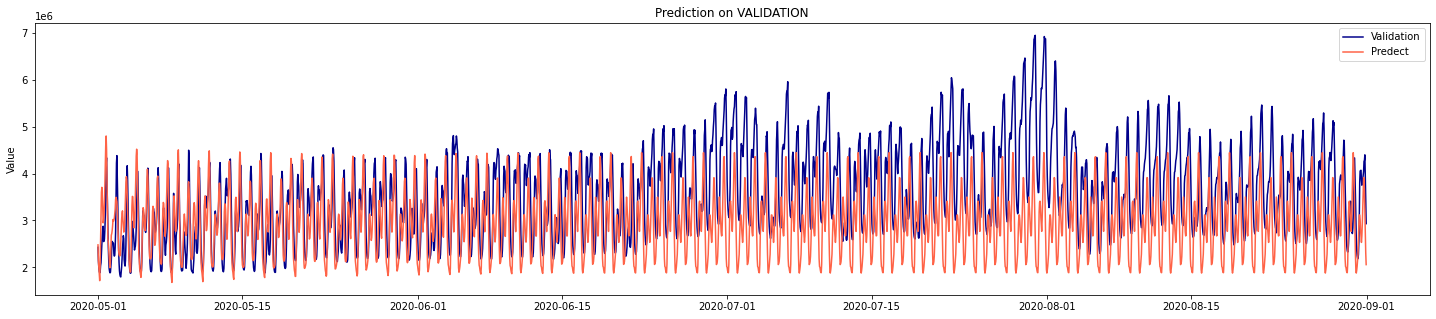

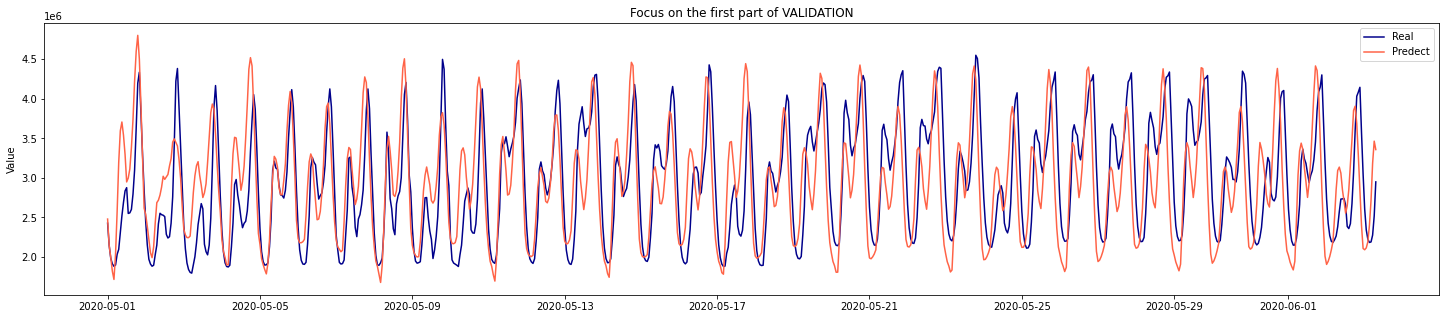

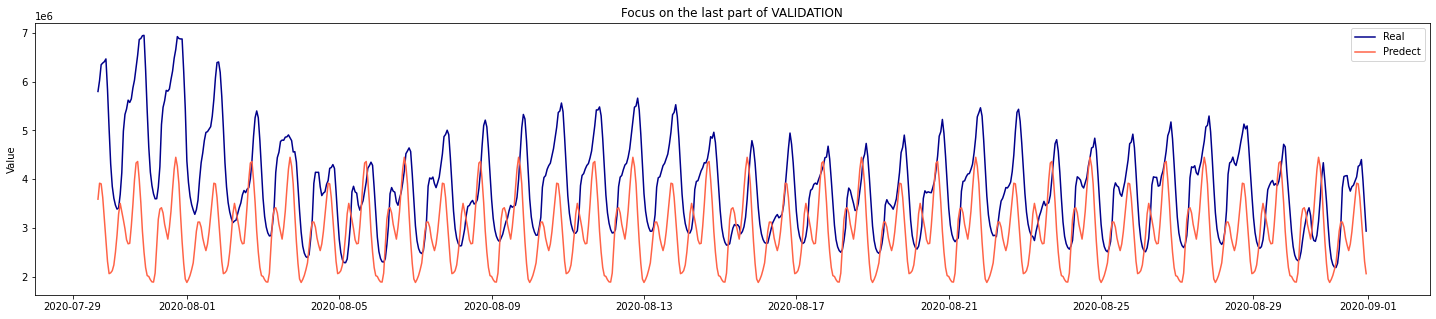

In [28]:
plot_finale(train, validation, pred_final ['Value'])
del model

### Modello LSTM - 1 week prediction

In [23]:
#Train / validation split
train = data.loc[:"2020-04-30 23:00:00"]
validation = data.loc["2020-05-01 00:00:00":]

train_scaled = data.loc[:"2020-04-30 23:00:00"].copy()
train_scaled, scaler = preprocess_data(train_scaled)

data_scaled = data.copy()
data_scaled, data_scaler = preprocess_data(data_scaled)

In [24]:
n_features = 1
n_steps_in, n_steps_out= 24*7, 24*7
X, y = data_preparation(n_steps_in, n_steps_out, train_scaled)

In [25]:
print(X.shape)
print(y.shape)

(14257, 168, 1)
(14257, 168, 1)


In [26]:
batch_size = 1

#define model
model = Sequential()
model.add(LSTM(200, batch_input_shape=(batch_size, n_steps_in, n_features), stateful=True)) 
model.add(LeakyReLU())
model.add(Dropout(0.2))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mae')
#model.summary()

for i in range(3):
	model.fit(X, y, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
	model.reset_states()

14257/14257 [==============================] - 351s 25ms/step - loss: 0.0441


In [27]:
#prediction on validation set
prev_st=[]
x_input = np.array(train_scaled[-n_steps_in:])
for i in range(int(len(validation)/n_steps_out)+1):
  x_input = x_input[-n_steps_in:]
  yhat = model.predict(x_input.reshape(1, n_steps_in, n_features), verbose=0, batch_size=batch_size)
  for j in range(n_steps_out):
    prev_st.append(yhat[0][j])
  x_input=np.vstack([x_input, yhat[0].reshape(yhat[0].shape[0], 1)])
  del yhat

In [28]:
prev = scaler.inverse_transform(np.array(prev_st).reshape(-1,1))
pred_final = pd.DataFrame(prev[:len(validation)], index=validation.index, columns=['Value'])

In [29]:
#performance of the model
_, y = data_preparation(n_steps_in, n_steps_out, train['Value'])
print("MAE train:", mean_absolute_error(scaler.inverse_transform(model.predict(X, batch_size=batch_size)), y))
print("MAE validation:", mean_absolute_error(validation['Value'], pred_final['Value']))

MAE train: 1405659.3
MAE validation: 740741.4


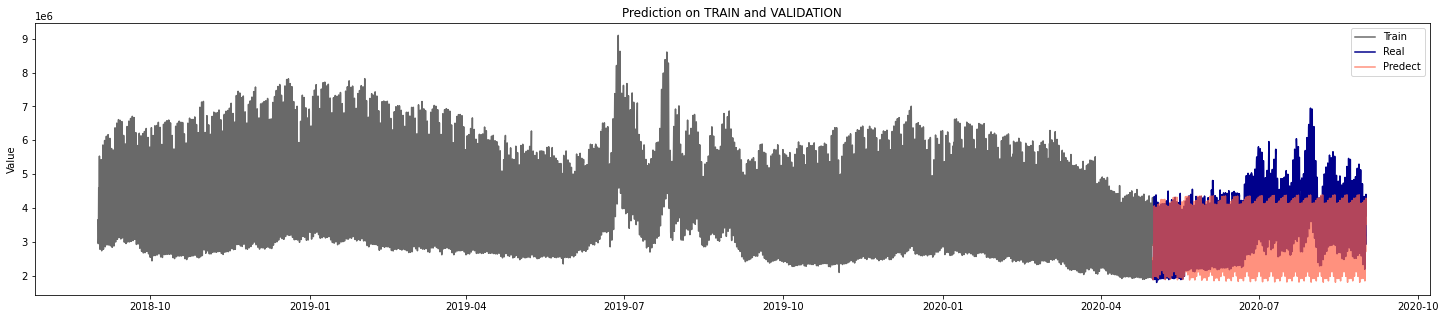

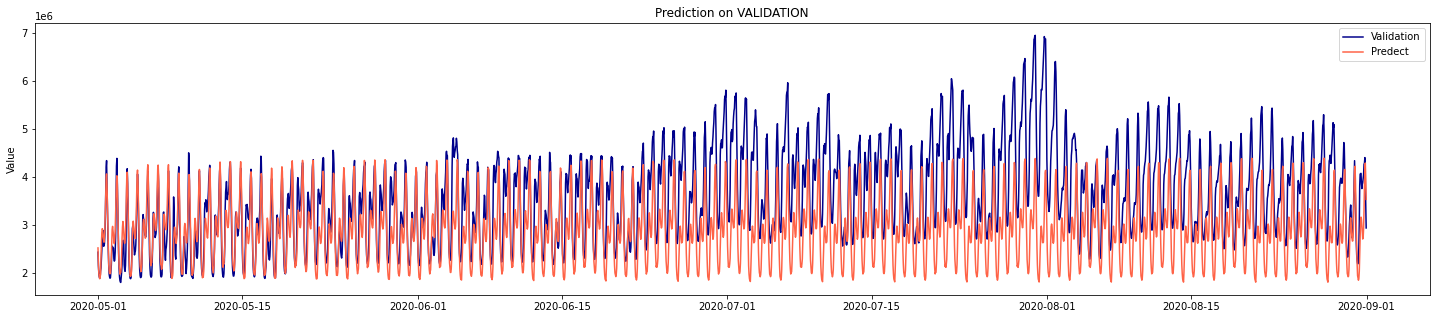

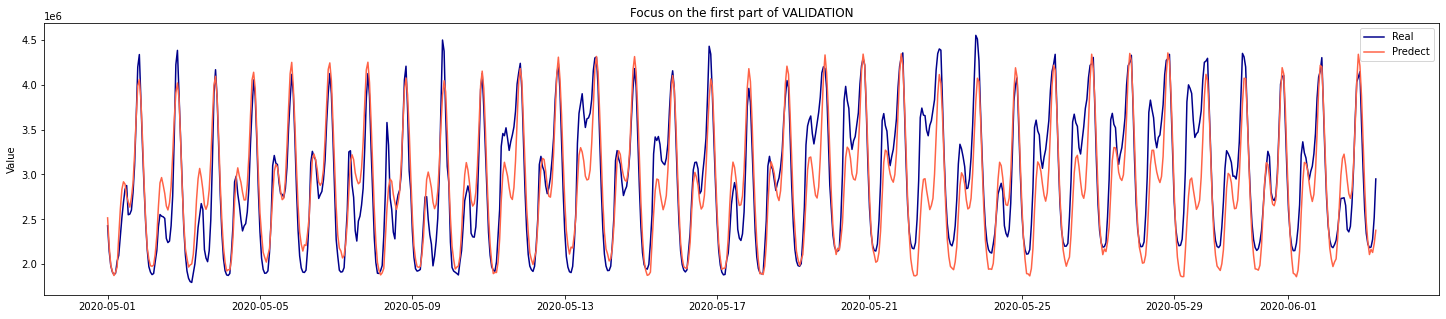

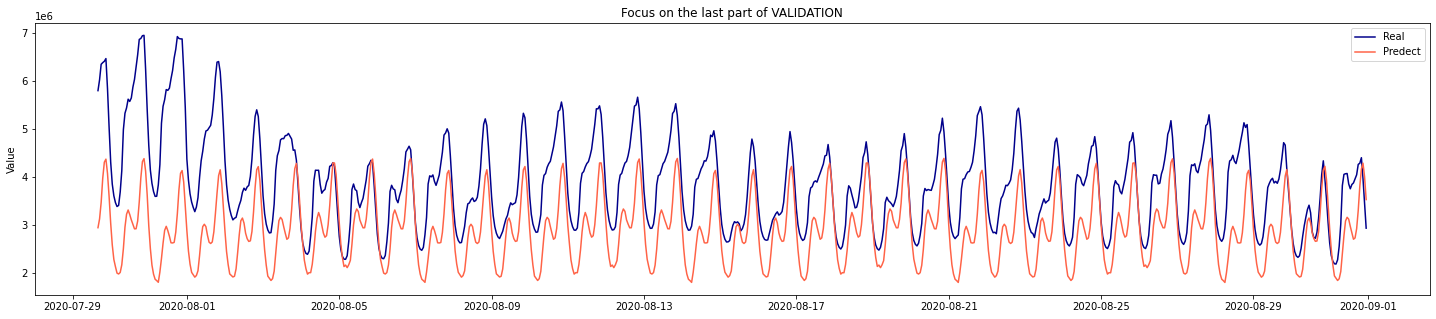

In [30]:
plot_finale(train, validation, pred_final ['Value'])
del model

### Previsioni

In [31]:
n_features = 1
n_steps_in, n_steps_out= 24*7, 24*7
X, y = data_preparation(n_steps_in, n_steps_out, data_scaled)

In [32]:
batch_size = 1

#define model
model = Sequential()
model.add(LSTM(200, batch_input_shape=(batch_size, n_steps_in, n_features), stateful=True)) 
model.add(LeakyReLU())
model.add(Dropout(0.2))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mae')
#model.summary()

for i in range(3):
	model.fit(X, y, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
	model.reset_states()

17209/17209 [==============================] - 426s 25ms/step - loss: 0.0419


In [33]:
len_for=len(pd.date_range(start="2020-09-01 00:00:00", end="2020-10-31 23:00:00", freq='H'))

In [34]:
#prediction on validation set
prev_st=[]
x_input = np.array(data_scaled[-n_steps_in:])
for i in range(int(len_for/n_steps_out)+1):
  x_input = x_input[-n_steps_in:]
  yhat = model.predict(x_input.reshape(1, n_steps_in, n_features), verbose=0)
  for j in range(n_steps_out):
    prev_st.append(yhat[0][j])
  x_input=np.vstack([x_input, yhat[0].reshape(yhat[0].shape[0], 1)])
  del yhat

In [52]:
#prev = scaler.inverse_transform(np.array(prev_st).reshape(-1,1))
#pred_final = pd.DataFrame(prev[:len(validation)], index=validation.index, columns=['Value'])

In [118]:
forecast = pd.DataFrame({'LSTM': prev_st[:len_for], 'Date': pd.date_range(start="2020-09-01 00:00:00", end="2020-10-31 23:00:00", freq='H')})
forecast.set_index('Date', inplace=True)
forecast['LSTM'] = data_scaler.inverse_transform(forecast)

In [119]:
forecast.reset_index(inplace=True)

In [120]:
forecast.to_csv('LSTM.csv')

## Results

In [104]:
def final_plot(data, final, mod, color):
  plt.figure(figsize=(25, 5))
  plt.title('Prediction with {} model' .format(mod))
  plt.plot(data['Value'], color='dimgrey')
  plt.plot(final[mod], color=color, alpha=0.7)
  plt.ylabel('Value')
  plt.show()

In [105]:
data=pd.read_csv('data_complete.csv', sep=',', header=0, low_memory=False, parse_dates=['Date_Hour'])
data.set_index('Date_Hour', inplace=True)

ARIMA=pd.read_csv('ARIMA.csv', parse_dates=['Date'])
ARIMA.set_index('Unnamed: 0', inplace=True)

UCM=pd.read_csv('UCM.csv', parse_dates=['Date'])
UCM.set_index('Unnamed: 0', inplace=True)

prophet=pd.read_csv('prophet.csv', parse_dates=['Date'])
prophet.set_index('Unnamed: 0', inplace=True)

LSTM=pd.read_csv('LSTM.csv', parse_dates=['Date'])
LSTM.set_index('Unnamed: 0', inplace=True)

In [130]:
final=prophet.merge(ARIMA).merge(UCM).merge(prophet).merge(LSTM)
final.set_index('Date', inplace=True)

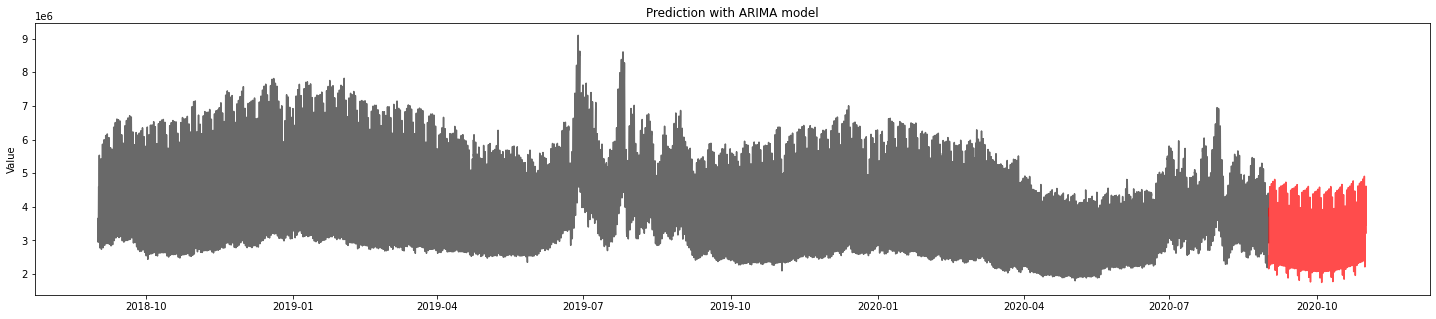

In [128]:
#plot ARIMA
final_plot(data, final, 'ARIMA', 'red')

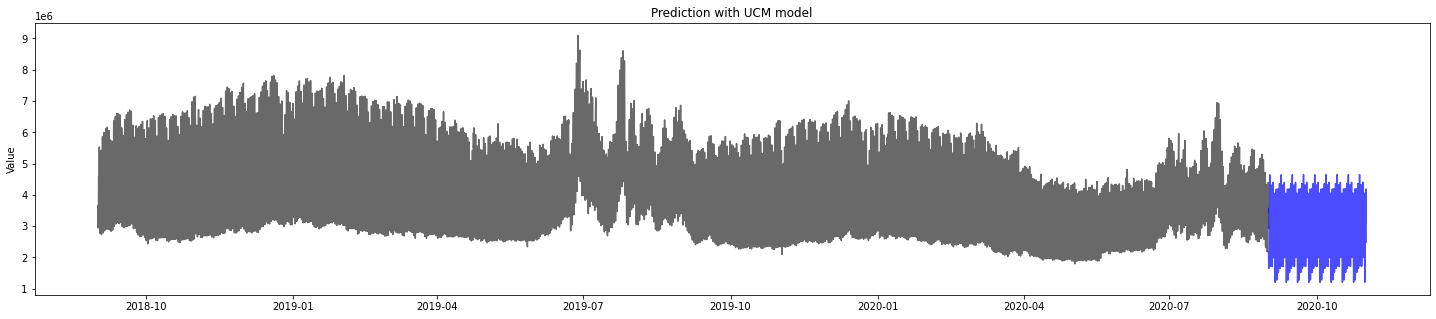

In [109]:
#plot UCM
final_plot(data, final, 'UCM', 'blue')

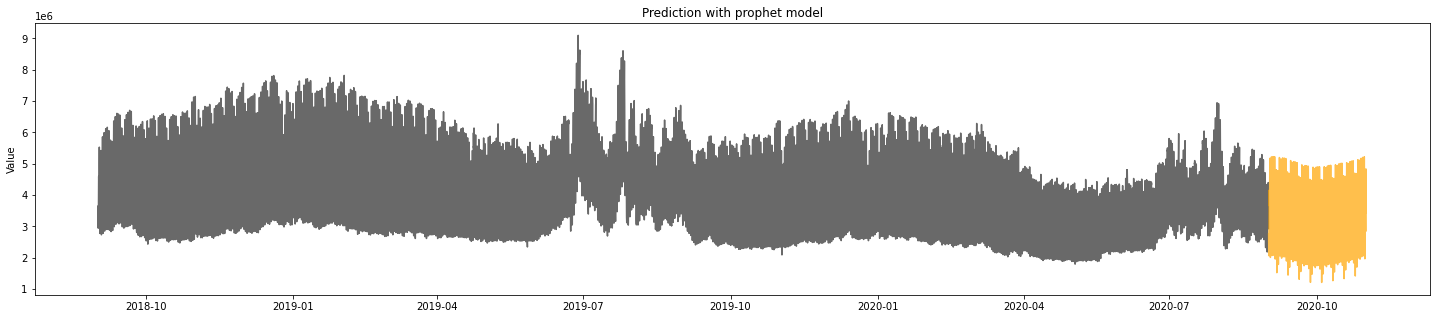

In [110]:
#plot prophet
final_plot(data, final, 'prophet', 'orange')

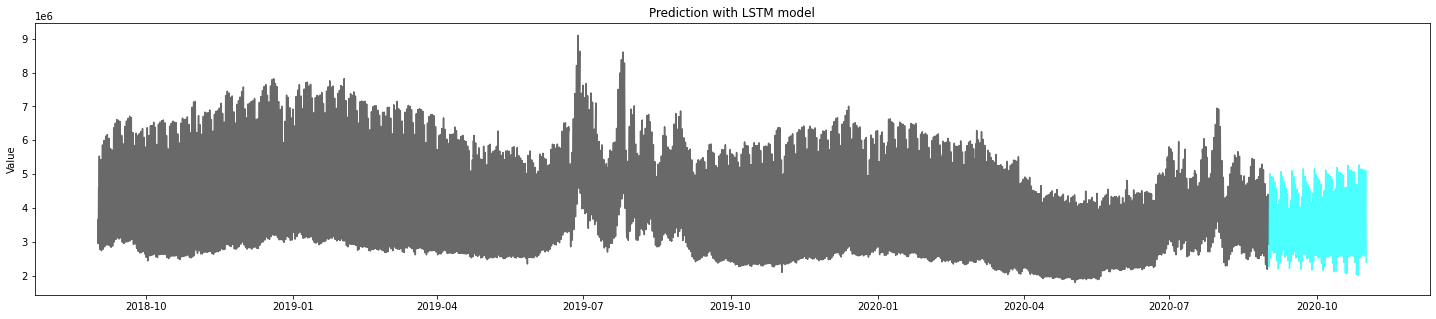

In [111]:
#plot LSTM
final_plot(data, final, 'LSTM', 'aqua')

In [131]:
submission=final.copy(deep=True)
submission['Data']=pd.to_datetime(submission.index.year.astype('str')+'-'+submission.index.month.astype('str')+'-'+submission.index.day.astype('str'),  format = "%Y-%m-%d" )
submission['Ora']=submission.index.hour
submission['Ora']=submission['Ora']+1
submission['Ora']=submission['Ora'].astype(str)

In [144]:
submission['prophet'] = submission['prophet'].round(0)
submission['UCM'] = submission['UCM'].round(0)
submission['ARIMA'] = submission['ARIMA'].round(0)
submission['ML'] = submission['ML'].round(0)

In [145]:
#I rearrange the columns
submission.rename(columns={"LSTM": "ML"}, inplace=True)
submission = submission[['Data', 'Ora', 'ARIMA',  'UCM', 'prophet','ML']]

In [147]:
#save to csv file
submission.to_csv('SDMTSA_864027.csv', sep=';', index=False)

In [148]:
pd.read_csv('SDMTSA_864027.csv', sep=';')

Data  Ora      ARIMA        UCM    prophet         ML
0     2020-09-01    1  2522914.0  2173922.0  2760962.0  2684810.0
1     2020-09-01    2  2289181.0  1840311.0  2404718.0  2400330.0
2     2020-09-01    3  2190110.0  1678104.0  2193043.0  2274955.0
3     2020-09-01    4  2153630.0  1646925.0  2070923.0  2258761.0
4     2020-09-01    5  2156501.0  1695907.0  2067915.0  2305763.0
...          ...  ...        ...        ...        ...        ...
1459  2020-10-31   20  4463121.0  4171453.0  4835845.0  3329413.0
1460  2020-10-31   21  4609545.0  4189546.0  4739927.0  2894596.0
1461  2020-10-31   22  4220816.0  3761944.0  4284275.0  2634362.0
1462  2020-10-31   23  3734230.0  3099268.0  3585609.0  2504496.0
1463  2020-10-31   24  3217708.0  2487626.0  2859881.0  2388093.0

[1464 rows x 6 columns]